# Time series on energy consumption
In this notebook, I will be performing time series to train models and predicting the energy usage, specifically gas, electricity, and water consumption. By doing so, we hope to be able to forecast the amount of energy usage for whatever reason.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.vector_ar.var_model import VAR

# suppress warnings as they can get really lengthy
import warnings
warnings.simplefilter('ignore')

Import data and view the sample.

In [87]:
energy_df = pd.read_csv('Energy Consumption Dataset.csv')
energy_df.head()

DATE  Gas Consumption (tons)  Electricity Consumption (MWh)  \
0  1/1/1990                    18.0                          725.1   
1  1/2/1990                    15.8                          706.7   
2  1/3/1990                    17.3                          624.5   
3  1/4/1990                    18.9                          574.7   
4  1/5/1990                    22.0                          553.2   

   Water Consumption (tons)  
0                     548.8  
1                     640.7  
2                     511.1  
3                     515.3  
4                     488.4

The dataset itself consists of gas, electricity, and water consumption monthly from 1990 to 2023.

Because I have no idea about the origin of this dataset, I would assume the data would represent the energy usage in general worldwide. I could also assume it would be in Singapore as well. So for now I would simply explain things in both context.

In [88]:
# check the shape of data
energy_df.shape

(397, 4)

Renaming the column names as they are lengthy and prone to making typos and forgetting how they are written.

In [89]:
# rename columns because I don't want to type very long
energy_df.rename(columns={'Gas Consumption (tons)' : 'Gas', 'Electricity Consumption (MWh)' : 'Electricity', 'Water Consumption (tons)' : 'Water'}, inplace=True)
energy_df.head()

DATE   Gas  Electricity  Water
0  1/1/1990  18.0        725.1  548.8
1  1/2/1990  15.8        706.7  640.7
2  1/3/1990  17.3        624.5  511.1
3  1/4/1990  18.9        574.7  515.3
4  1/5/1990  22.0        553.2  488.4

Check for any missing values.

In [90]:
# prints for number of null values
print(energy_df.isnull().sum())

DATE           0
Gas            0
Electricity    0
Water          0
dtype: int64


Since we are dealing with dates in time series, I would have to ensure that the date column is in datetime dtype.

In [91]:
energy_df['DATE'] = pd.to_datetime(energy_df['DATE'], format='%d/%m/%Y')
energy_df.head()

DATE   Gas  Electricity  Water
0 1990-01-01  18.0        725.1  548.8
1 1990-02-01  15.8        706.7  640.7
2 1990-03-01  17.3        624.5  511.1
3 1990-04-01  18.9        574.7  515.3
4 1990-05-01  22.0        553.2  488.4

In [92]:
energy_df[['Gas', 'Electricity', 'Water']].corr()

Gas  Electricity     Water
Gas          1.000000     0.135056 -0.387813
Electricity  0.135056     1.000000  0.222002
Water       -0.387813     0.222002  1.000000

In [93]:
energy_df[['Gas', 'Electricity', 'Water']].pct_change().corr()

Gas  Electricity     Water
Gas          1.000000     0.006170 -0.227091
Electricity  0.006170     1.000000 -0.038123
Water       -0.227091    -0.038123  1.000000

By simply using Pandas' built-in correlation matrix, we can easily observe that electricity has weak correlation with gas and water while water and gas has a weak or moderate negative correlation. And also by observing the percentage changes correlation, we can clearly see the change of electricity has no correlation with water and gas, but there is a weak correlation change between water and gas. There seems to be some relationship between gas and water, but not so with electricity. I could not find any articles that discuss the negative correlation between water and gas consumption on certain period of the year or over the years. I will later do the granger causality test to see if any columns cause other columns, I delay doing it because I need to see if all the columns are stationary before I can do the test (Prabhakaran, S. (2022)).

We can plot line graphs for each energy type for some visualisation of our data.

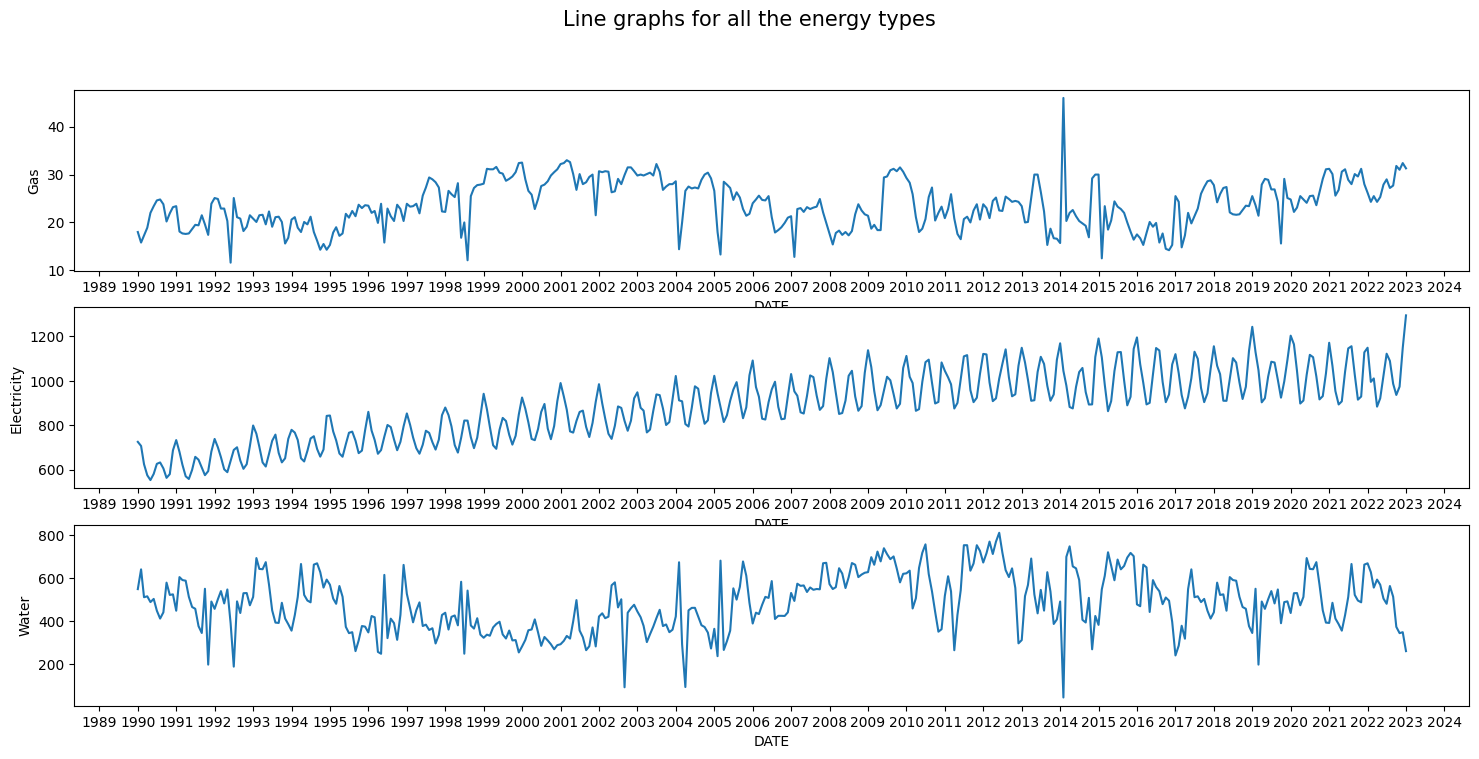

<Figure size 1600x800 with 0 Axes>

In [94]:
# 3 subplots lay vertically
fig, axes = plt.subplots(3, 1)

# manually set the width and height of the figures longer
fig.set_figwidth(18)
fig.set_figheight(8)
fig.suptitle('Line graphs for all the energy types', fontsize=15)

# iterate over the list of axes and plot a line graph for each axes
for i, ax in enumerate(axes):
    sns.lineplot(data=energy_df, x='DATE', y=energy_df.columns[i + 1], ax=ax)

    # use the matplotlib's date locater and formatter such that I only want to display the years rather than all the months
    locator = mdates.YearLocator()
    formatter = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

plt.show()
plt.clf()

Based on the line graphs, we can already see that:
1. We can see slight visible trend for the gas: From 1990 to 1995, it seems like the gas consumption trend remain constant or slightly drop, and the trend slightly went up and peak in the year 2000 before going back down slightly until 2007. The trend then appear to slightly go back up again, peak around late-2011 or early-2012, before going down slightly and lower in 2016, before going back up in 2017 and it may seem to reach its peak at the current moment. So in the long run, there seems to be some kind of "long-term seasonal" pattern for the gas column. But when it comes to actual seasonal pattern (like each season for each year), I can't tell any pattern from the graph itself.
2. The trend for the electricity is somewhat obvious, it slowly peak from 1990 to the early 2010s before it plateau all the way to the present moment. On the other hand, the trend for the water seems to be slightly difficult to observe due to the huge variance that occur throughout. The water consumption trend might be going down slightly from 1990 to the early 2000s before going up and stay somewhat constant. 
3. When it comes to seasonality, electricity will be the most easiest to pick up by eye. Say from 1990 to 1991, the electricity consumption peak in Jan, and then decline and went back up in the middle of the year, before going down again and peak in Dec 1990/Jan 1991. The season seems to remain relatively the same throughout the years, except that the variance may have grown slightly in time as well. Unfortunately for gas and water, it is nearly impossible to pick up any seasons by eye.
4. One interesting note is that somewhere in early 2014, gas consumption peaked above 40 tons, making it an eye sore outlier. This outlier seem to coincide with the lowest water consumption in the entire dataset. In fact, how deep down did the water consumption go?

In [95]:
print(f'Month of gas spike: {energy_df["DATE"][energy_df["Gas"].idxmax()]}')
print(f'Month of least water consume: {energy_df["DATE"][energy_df["Water"].idxmin()]}')
print(f'Least water consumed: {np.min(energy_df["Water"])} tons')

Month of gas spike: 2014-02-01 00:00:00
Month of least water consume: 2014-02-01 00:00:00
Least water consumed: 44.4 tons


Seems like the spike in gas consumption and the lowest water consumption actually coincide. And the least water consume dips so low that it is more than 10 times than some of the other times. But for the gas on that month, it seems to follow the seasonal pattern when looking at the graph, making this month an interesting outlier for both the gas and water consumption. However, they are not wild numbers like extreme high or even straight out 0, which would mean something is wrong with the way the data is being collected. So I will treat the outlier as normal.

The next thing I will do is time series decomposition whereby I separate the time series into 3 components: Trend, seasonal, and residual. This allows me to observe the trend for each energy type, the seasonal (or periodic) pattern, as well as the residual, or the noise of the data.

In [96]:
# drop the date column into index
new_energy_df = energy_df.copy(deep=True).set_index('DATE')
new_energy_df.index = pd.DatetimeIndex(new_energy_df.index, freq='MS')
new_energy_df.head()

Gas  Electricity  Water
DATE                                
1990-01-01  18.0        725.1  548.8
1990-02-01  15.8        706.7  640.7
1990-03-01  17.3        624.5  511.1
1990-04-01  18.9        574.7  515.3
1990-05-01  22.0        553.2  488.4

Unique seasonal count: 12


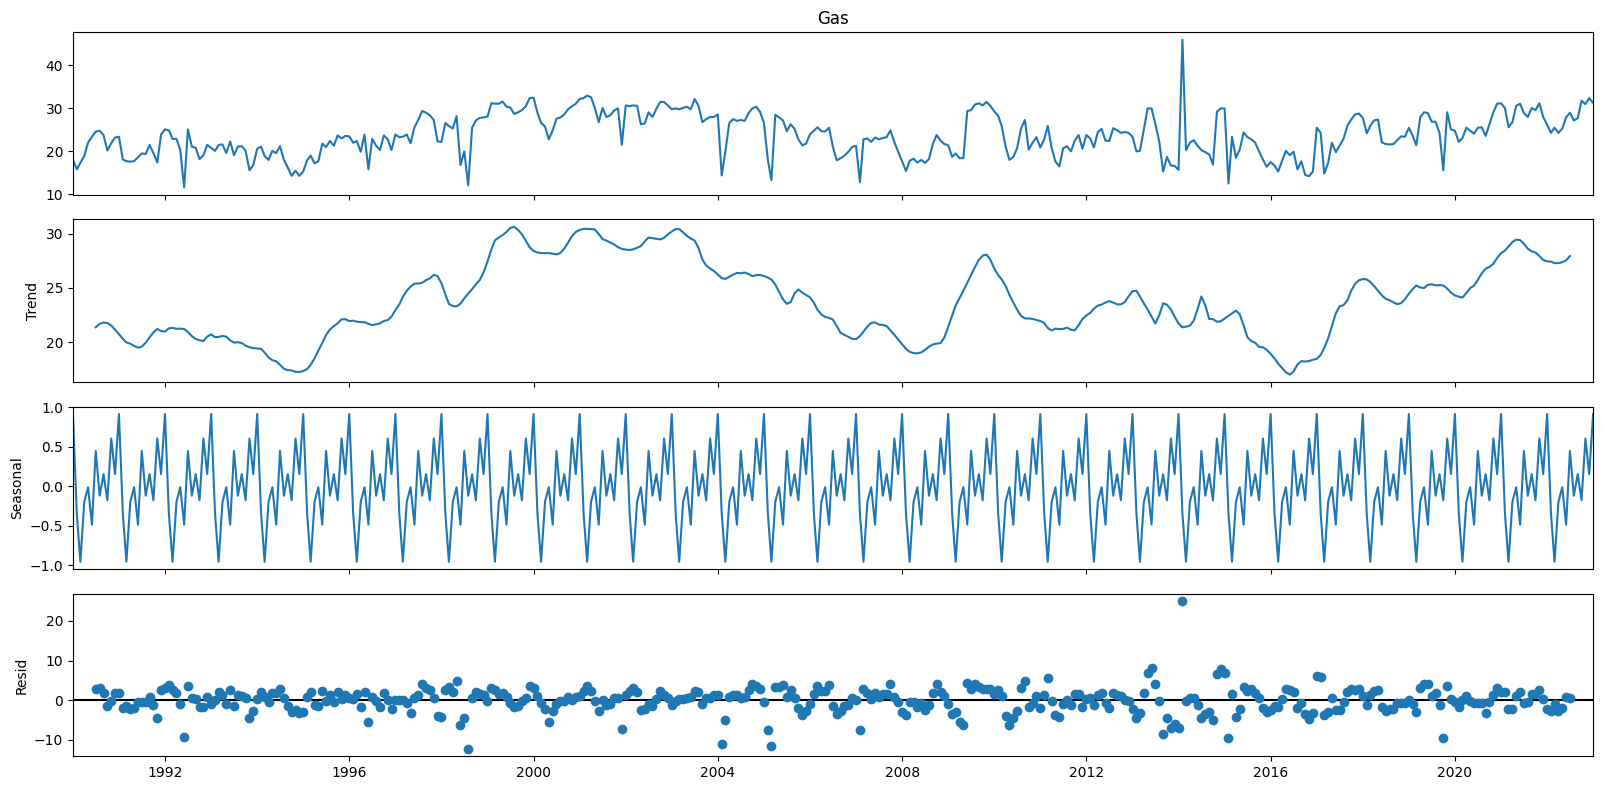

Unique seasonal count: 12


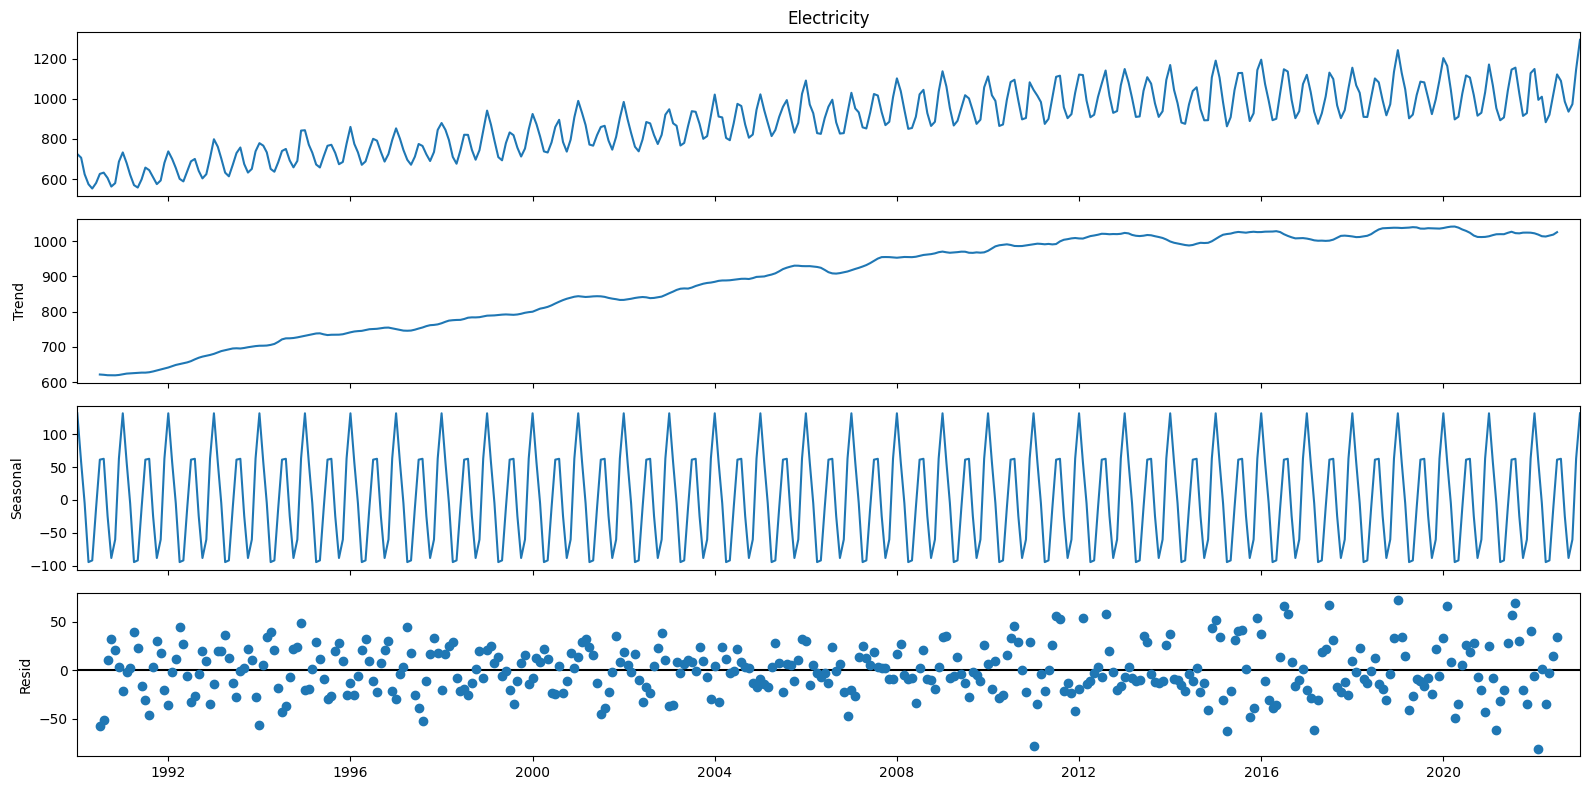

Unique seasonal count: 12


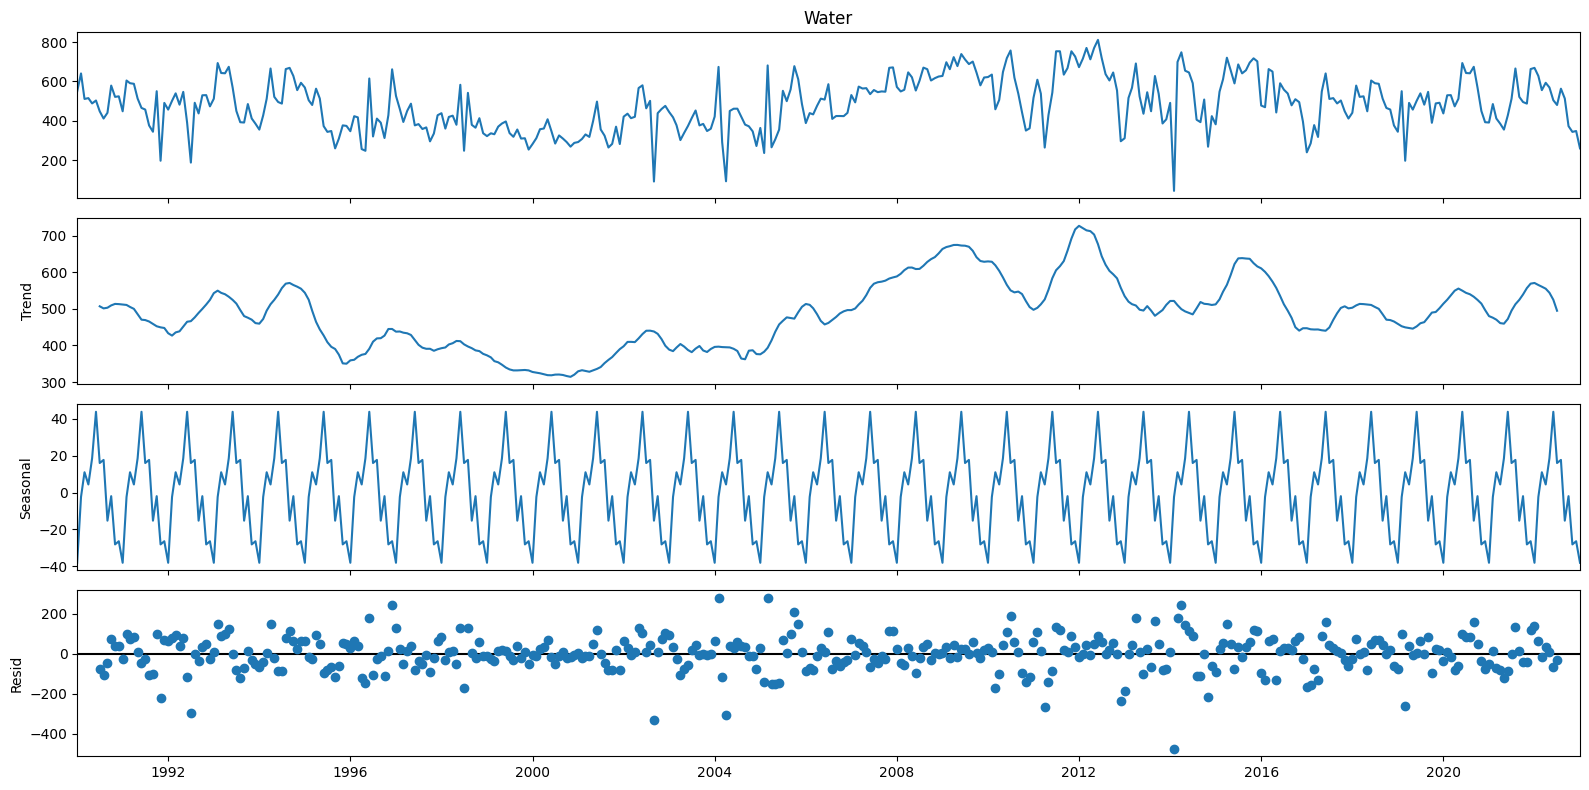

In [97]:
# iterate over the dataframe columns and do time seasonal decomposition for each of the columns
for col in new_energy_df.columns:
    plt.rc("figure", figsize=(16, 8))   # readjust the figure so I can have bigger view of the graph
    decompose = seasonal.seasonal_decompose(new_energy_df[col], model='additive')   # opted for additive because trend and seasonality seems to be "constant"
    print(f'Unique seasonal count: {len(np.unique(decompose.seasonal))}')   # shows how many unique seasonal values are there
    decompose.plot()
    plt.show()

Based on the time series decomposition, we can observe that:
1. There is no linear trend among all the columns. Though the electricity column seem to almost have a positive linear trend, but is not perfectly linear as the trend plateau in the early-2010s.
2. Interestingly, all 3 columns have the same number of unique season values, which is 12, which is basically the whole period lasting one whole year. So not only does electricity has the whole seasons that last one year, gas and water also follow the same, but the seasonality values are pretty small for the water and gas relative to their original values before decomposition.

Next, I will be observing the autocorrelation on the variables. This will allow me to see how the data correlates its lagged self, and in our case, correlating the energy use to n number of months earlier where n is the lagged value. As much as I want to use pandas' autocorr() method and implement a for loop to display all the values, statsmodels offer a more conveninent tool to observe even with a graph and show the confidence interval that is easy to use and see. And before I plot the ACF and PACF graph, I need to ensure that the data is stationary so that I can use it to look for values for the ARIMA p and q values.

To determine whether the columns of data are stationary, I will use the Augmented Dickey-Fuller test, which checks if a time series data has a unit root or not. A unit root is a mathematical property that makes a time series non-stationary, meaning it has a trend and doesn't remain constant over time. To test for stationarity, here are the hypotheses:

H0: There exists the unit root, which means the time series is non-stationary.

H1: There doesn't exists the unit root, which means the time series is stationary.

In [98]:
for col in new_energy_df.columns:
    print(f'P-value for {col}: {adfuller(new_energy_df[col])[1]}')

P-value for Gas: 0.010810651707060609
P-value for Electricity: 0.1862180230033676
P-value for Water: 8.984549388336973e-05


Apparently, only electricity is not stationary. So I would have to do differencing on that column and then try again. But, I have a dilemma, should I do normal differencing, or seasonal differencing? When I want to do ARIMA, normal differencing will retain the seasonality, thus allowing the model to predict with seasonality, but expect some residuals to be significantly correlated. On the other hand, if I do seasonal differencing, the ARIMA model will not know about the season, and I expect the model to not know how to predict with seasonality. So what would I do? Experiment, of course. I will have two new columns, one with normal differencing, the other would have normal and seasonal differencing (to detrend and remove the seasonality).

In [99]:
station_energy_df = new_energy_df.copy(deep=True)

# using pandas built-in method .diff() to do the differencing
station_energy_df['Electricity_normal_diff'] = station_energy_df['Electricity'].diff()
station_energy_df['Electricity_season_diff'] = station_energy_df['Electricity_normal_diff'].diff(12)

# once I do the differencing, there will be null values in the electricity column
# I am not dropping off because I will also be dropping off value for the other columns, so I will drop when plotting only for electricity
# I can only do this when I am doing univariate time series, but when doing multivariate, I have to do it differently

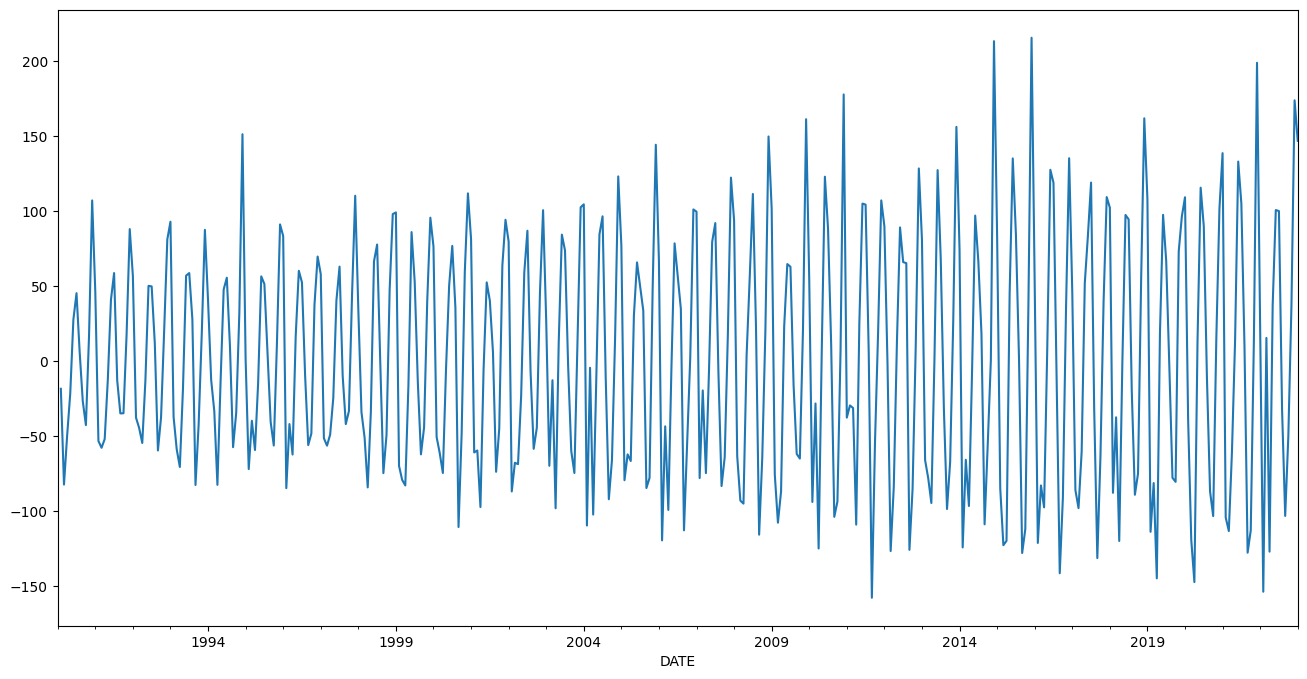

In [100]:
station_energy_df['Electricity_normal_diff'].plot()
plt.show()

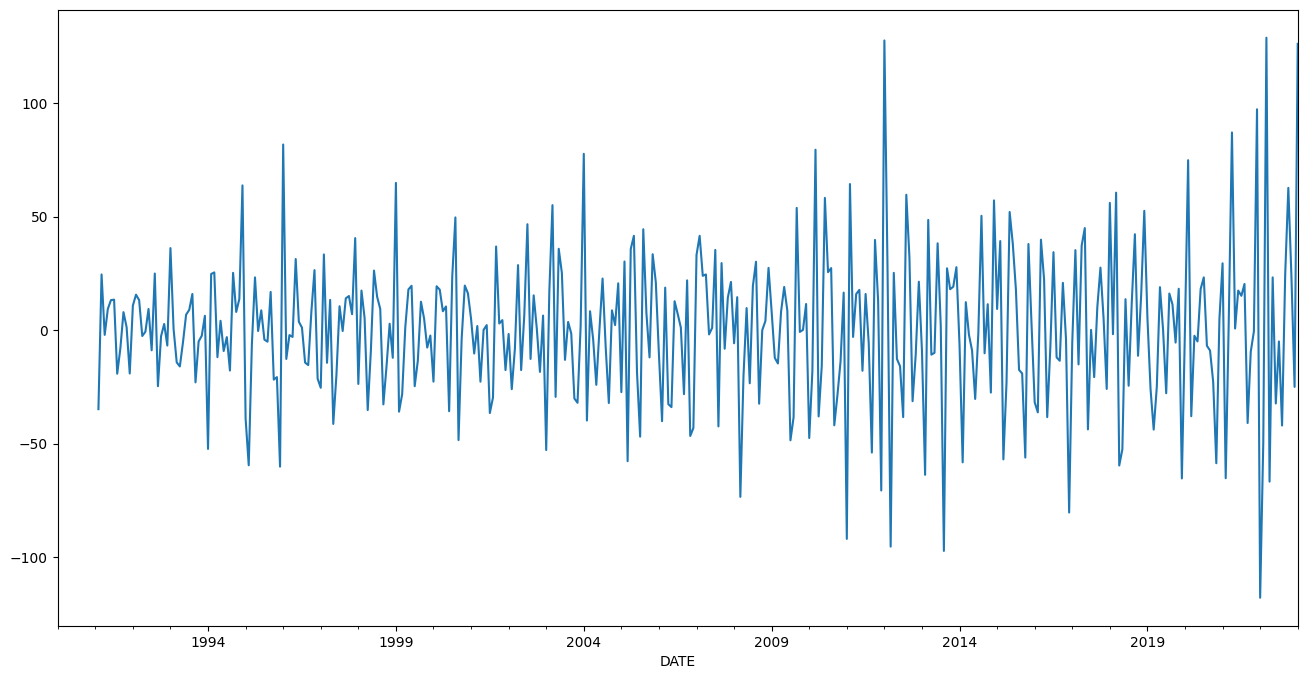

In [101]:
station_energy_df['Electricity_season_diff'].plot()
plt.show()

As expected, the normal differencing still shows the seasonality, while the normal + seasonal differencing show the remnants after removing the trend and seasonality.

In [102]:
# do the test again with the new dataframe
print(f'P-value for electricity with normal differencing: {adfuller(station_energy_df["Electricity_normal_diff"].dropna())[1]}')
print(f'P-value for electricity with seasonal differencing: {adfuller(station_energy_df["Electricity_season_diff"].dropna())[1]}')

P-value for electricity with normal differencing: 4.0797707437855877e-10
P-value for electricity with seasonal differencing: 2.06020213302895e-12


Now seems like the electricity columns are now normal after differencing. I can do the Granger Causality test. This test determines whether a variable can influence another variable. In other words, does a variable significantly cause another variable? This does not mean A cause B, it simply means there's some kind of correlation. By conducting this test, I can determine whether to use exogenous variable for ARIMA and determining whether I can use the Vector Auto Regression (VAR) algorithm as well. Here are the hypothesis:

H0: Variable X do not Granger cause variable Y

H1: Variable X Granger cause variable Y

In [103]:
cols = ['Gas', 'Water', 'Electricity_normal_diff', 'Electricity_season_diff']
# create an "empty matrix" so that I can visualise how one variable cause another variable 
matrix_df = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)

# iterate over columns and rows of the "matrix"
for col in matrix_df.columns:
    for row in matrix_df.index:
        # do the test and get the P-value which will be rounded off to 4 DP because I don't need a long number, and get the minimum p-value
        results = grangercausalitytests(station_energy_df.dropna()[[row, col]], maxlag=12, verbose=False)
        p_value = np.min([round(results[i + 1][0]['ssr_chi2test'][1], 4) for i in range(12)])
        matrix_df.loc[row, col] = p_value

matrix_df.columns = [f'{col} cause' for col in cols]
matrix_df.index = [f'{col} effect' for col in cols]
matrix_df

Gas cause  Water cause  \
Gas effect                         1.0000       0.2714   
Water effect                       0.0296       1.0000   
Electricity_normal_diff effect     0.3386       0.1009   
Electricity_season_diff effect     0.1273       0.1873   

                                Electricity_normal_diff cause  \
Gas effect                                             0.2737   
Water effect                                           0.3878   
Electricity_normal_diff effect                         1.0000   
Electricity_season_diff effect                         0.0000   

                                Electricity_season_diff cause  
Gas effect                                             0.3816  
Water effect                                           0.1506  
Electricity_normal_diff effect                         0.0000  
Electricity_season_diff effect                         1.0000

Based on the result, we can see that only Gas granger cause Water, but not the other way round. This is a uni-direction relationship, where one variable influence another variable, but not the other way round. Unfortunately, this means I can't use VAR model because both variables need to be able to influence one another, or in other ways, the two time series relationship must be bi-directional. On the brighter side, when I want to do ARIMA, I can use the Gas exogenous variable to do time series for water.

Also note that the both the Electricity normal differenced and Electricity season differenced columns has P-value of 0 in both directions. They are actually the same variable but with different ways of differencing so I don't count them. 

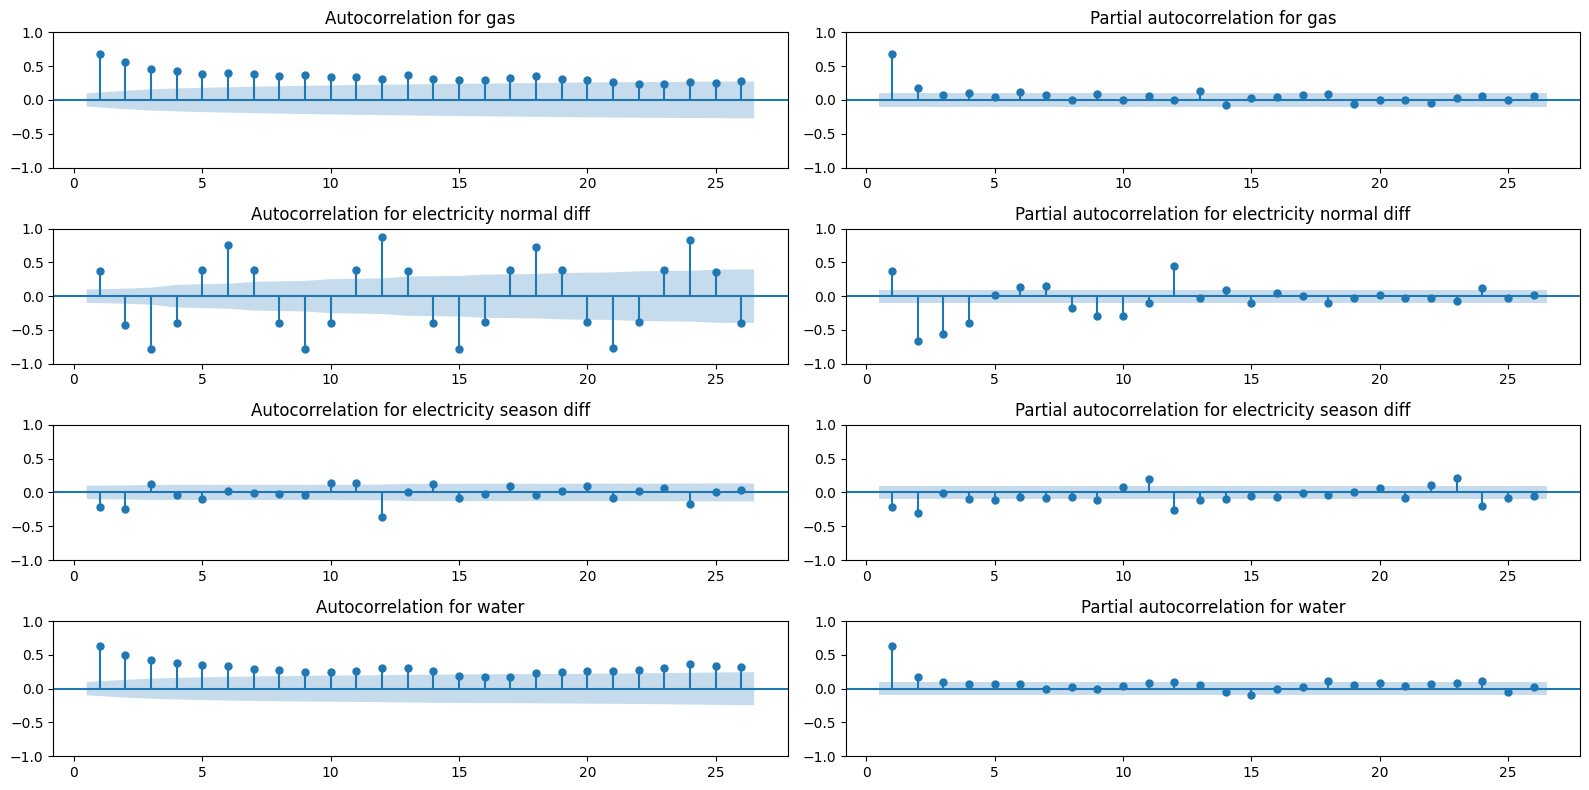

In [104]:
fig, axes = plt.subplots(4, 2)

plot_acf(station_energy_df['Gas'].dropna(), alpha=0.05, title=f'Autocorrelation for gas', zero=False, ax=axes[0, 0])
plot_pacf(station_energy_df['Gas'].dropna(), alpha=0.05, title=f'Partial autocorrelation for gas', zero=False, ax=axes[0, 1])
plot_acf(station_energy_df['Electricity_normal_diff'].dropna(), alpha=0.05, title=f'Autocorrelation for electricity normal diff', zero=False, ax=axes[1, 0])
plot_pacf(station_energy_df['Electricity_normal_diff'].dropna(), alpha=0.05, title=f'Partial autocorrelation for electricity normal diff', zero=False, ax=axes[1, 1])
plot_acf(station_energy_df['Electricity_season_diff'].dropna(), alpha=0.05, title=f'Autocorrelation for electricity season diff', zero=False, ax=axes[2, 0])
plot_pacf(station_energy_df['Electricity_season_diff'].dropna(), alpha=0.05, title=f'Partial autocorrelation for electricity season diff', zero=False, ax=axes[2, 1])
plot_acf(station_energy_df['Water'].dropna(), alpha=0.05, title=f'Autocorrelation for water', zero=False, ax=axes[3, 0])
plot_pacf(station_energy_df['Water'].dropna(), alpha=0.05, title=f'Partial autocorrelation for water', zero=False, ax=axes[3, 1])
plt.tight_layout()

plt.show()

Below is a table on how to identify which model can be used on which time series. Table taken from the DataCamp course on "ARIMA Models in Python".

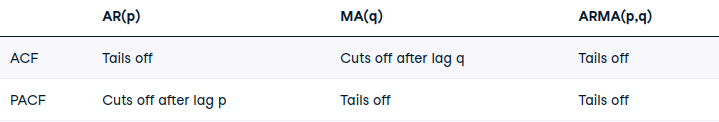

Based on conventional knowledge on identifying Auto-regressive (AR) or Moving-Average (MA), or combined ARMA models, we can observed that:
1. Gas is an AR model, as the ACF graph shows the value tailing off, while PACF graph shows the cut off after lag 1
2. Electricity with normal differencing is probably an ARMA model. The ACF graph shows season slowly tailing off, while for PACF graph, it can be seen as a cut off.
3. Electricity with seasonal differencing seems to have cut off for both ACF and PACF. Interesting note is that both ACF and PACF lag-1 is slightly negative. According to rule 7 of the article (Nau, R. (2020)), "If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model." So I can consider this to follow the MA model.
4. For water, the ACF might be non-stationary given that the tail went slightly below the CI but went back up. While in PACF, it can be interpreted as a cut off after lag 1.

With this knowledge, we can start building on univariate AR/MA/ARMA models to produce the forecasting. Based on what we have gather, we can deduce that Gas, and Water time series follow the AR(2) model, which will be the following equation:

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \varepsilon_t$

While the Electricity with normal differencing follows the AR(4):

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} + \varepsilon_t$

And finally, for the Electricity with seasonal differencing, when referring back to rule 7 of the article I cited just now, "The lag beyond which the ACF cuts off is the indicated number of MA terms." Hence, this time series follows the MA(2) model:

$y_t = c + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \varepsilon_t$

Before I would build the model, I would first split the dataset into their own respective dataframe. Basically, since this is a univariate time series, I just need one column of values for each model. Then, for each column of data, I would split it into training and testing so that I can observe how the prediction goes compares with the actual values. And keep in mind that because I have manually differenced the Electricity data, I need to reconstruct back the differenced data together with the forecasted value. The reason I do not use the ARIMA's differencing is because it does not seem to provide a way to difference seasonality.

In [105]:
# split the dataset into its own dataframe
gas_df = station_energy_df['Gas']
electricity_norm_diff_df = station_energy_df['Electricity_normal_diff'].dropna()
electricity_sea_diff_df = station_energy_df['Electricity_season_diff'].dropna()
water_df = station_energy_df['Water']

In [106]:
# split dataset into training and testing
# knowing that the data last until 2023 january, and is a monthly data, I can find a year to split
cut_off = date(2021, 1, 1)   # variable for me to set where I want to cut off between training and testing set
training_cutoff = cut_off - relativedelta(months=1)

gas_train, gas_test = gas_df.loc[:training_cutoff], gas_df.loc[cut_off:]
electricity_nd_train, electricity_nd_test = electricity_norm_diff_df[:training_cutoff], electricity_norm_diff_df[cut_off:]
electricity_sd_train, electricity_sd_test = electricity_sea_diff_df[:training_cutoff], electricity_sea_diff_df[cut_off:]
water_train, water_test = water_df[:training_cutoff], water_df[cut_off:]

When doing ARIMA, I would also like to add that I am using exogenous variable for the Water model simply because earlier I did the granger causality test, and Gas seems to granger cause the Water variable. So I will be adding the Gas exogenous variable into the Water time series.

In [107]:
# first off, gas time series
gas_model = ARIMA(gas_train, order=(2, 0, 0)).fit()
gas_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Gas   No. Observations:                  372
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1003.149
Date:                Fri, 11 Aug 2023   AIC                           2014.298
Time:                        21:47:29   BIC                           2029.974
Sample:                    01-01-1990   HQIC                          2020.523
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4729      0.690     33.998      0.000      22.120      24.826
ar.L1          0.5435      0.033     16.243      0.000       0.478       0.609
ar.L2          0.1800      0.042      4.272      0.000       0.097       0.263
sigma2        12.8541      0.548     23.443      0.000      11.779      13.929
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2078.34
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

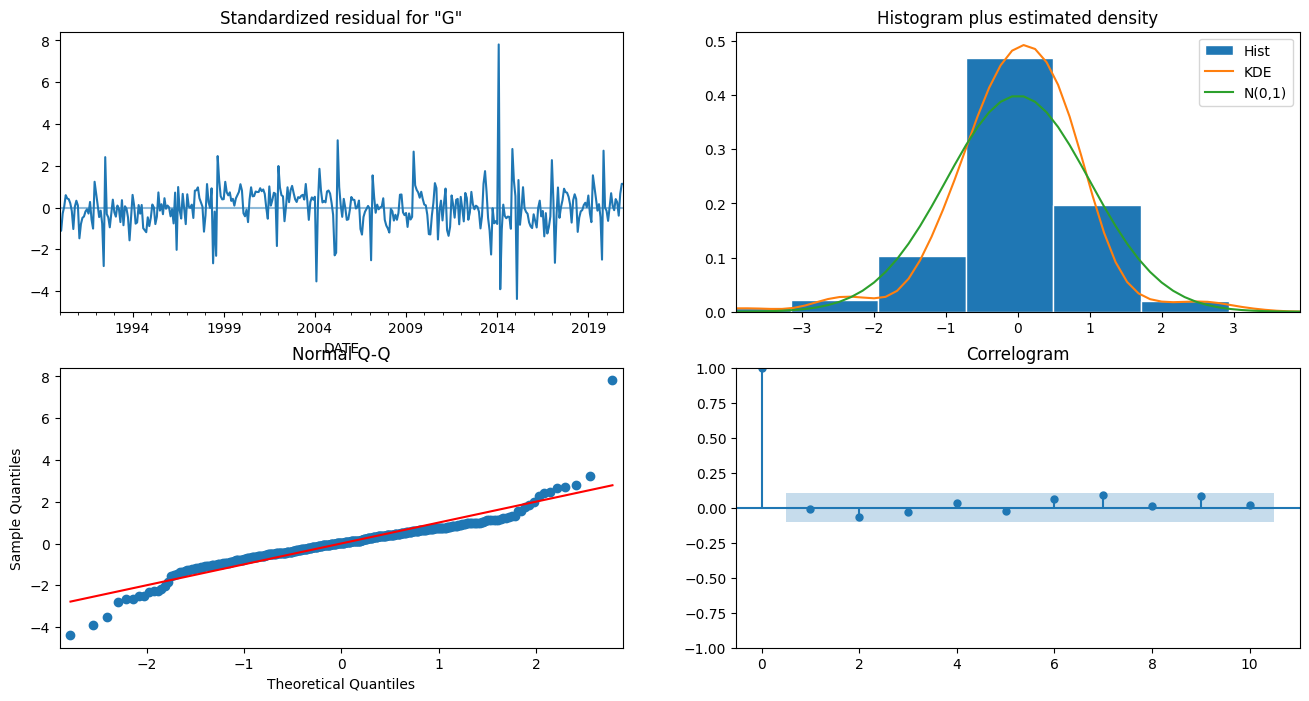

In [108]:
_ = gas_model.plot_diagnostics()    # the reason I assign the plot diagnostics to a "throwaway" variable is to prevent duplicate plot

In [109]:
electricity_nd_model = ARIMA(electricity_nd_train, order=(4, 0, 0)).fit()
electricity_nd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Electricity_normal_diff   No. Observations:                  371
Model:                      ARIMA(4, 0, 0)   Log Likelihood               -1867.272
Date:                     Fri, 11 Aug 2023   AIC                           3746.543
Time:                             21:47:29   BIC                           3770.040
Sample:                         02-01-1990   HQIC                          3755.875
                              - 12-01-2020                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0270      0.845      1.215      0.224      -0.629       2.683
ar.L1         -0.0173      0.042     -0.410      0.682      -0.100       0.066
ar.L2         -0.4334      0.040    -10.876      0.000      -0.511      -0.355
ar.L3         -0.4881      0.038    -12.997      0.000      -0.562      -0.415
ar.L4         -0.4333      0.048     -8.985      0.000      -0.528      -0.339
sigma2      1368.1957     95.509     14.325      0.000    1181.002    1555.390
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                10.01
Prob(Q):                              0.65   Prob(JB):                         0.01
Heteroskedasticity (H):               1.74   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

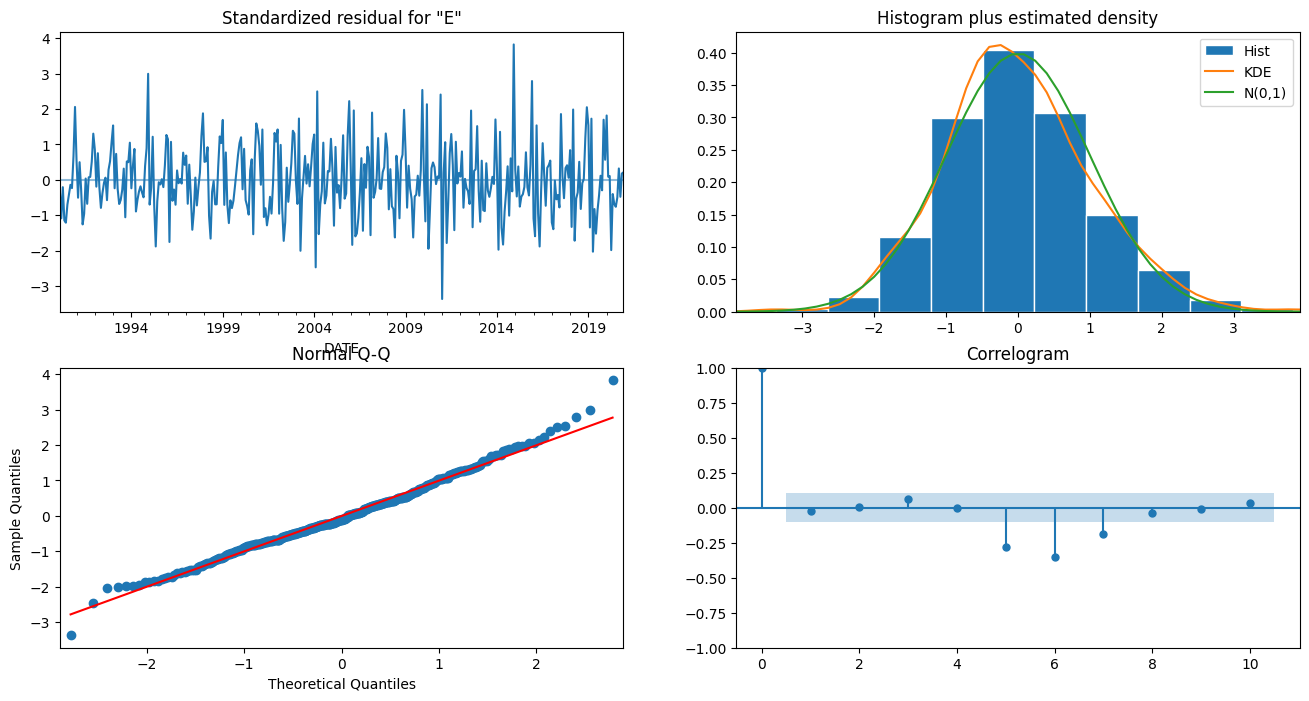

In [110]:
_ = electricity_nd_model.plot_diagnostics()

In [111]:
electricity_sd_model = ARIMA(electricity_sd_train, order=(0, 0, 2)).fit()
electricity_sd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Electricity_season_diff   No. Observations:                  359
Model:                      ARIMA(0, 0, 2)   Log Likelihood               -1695.336
Date:                     Fri, 11 Aug 2023   AIC                           3398.672
Time:                             21:47:30   BIC                           3414.205
Sample:                         02-01-1991   HQIC                          3404.849
                              - 12-01-2020                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0616      0.020     -3.035      0.002      -0.101      -0.022
ma.L1         -0.4502      3.094     -0.146      0.884      -6.514       5.614
ma.L2         -0.5498      1.710     -0.322      0.748      -3.900       2.801
sigma2       729.1363   2267.565      0.322      0.748   -3715.209    5173.482
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):                11.73
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

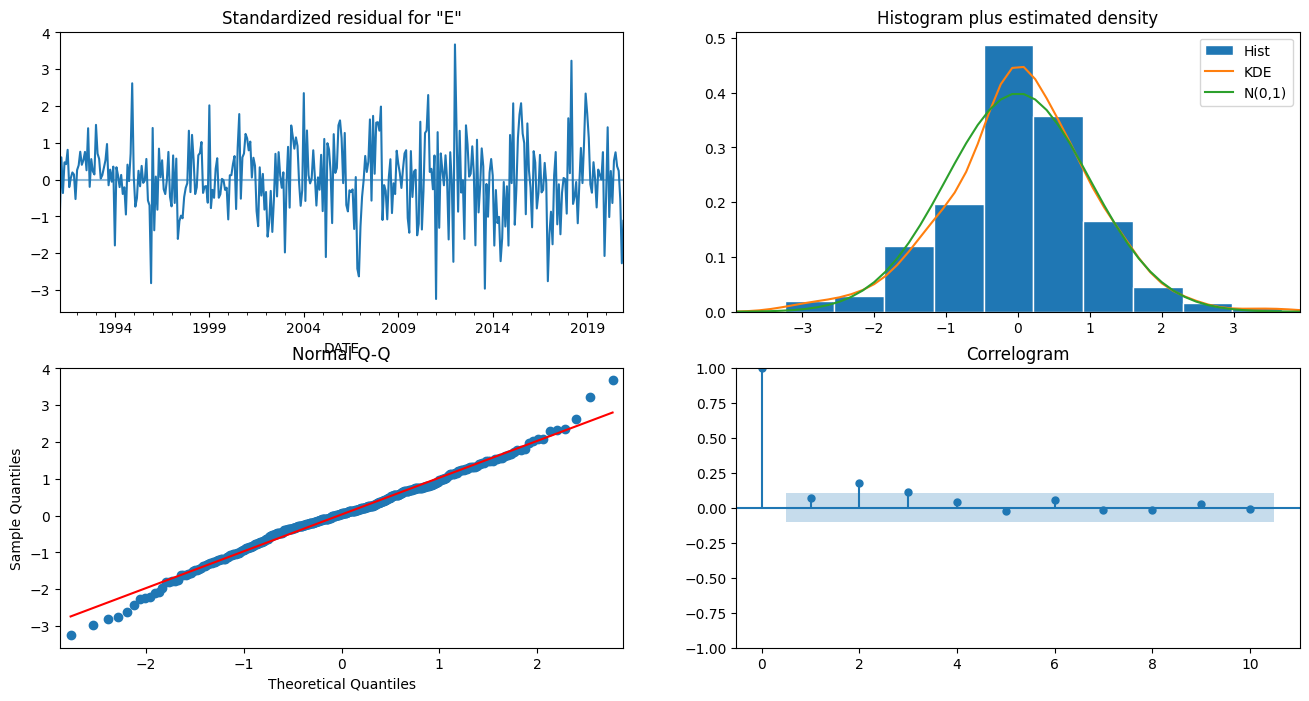

In [112]:
_ = electricity_sd_model.plot_diagnostics()

In [113]:
water_model = ARIMA(water_train, order=(2, 0, 0), exog=gas_train).fit()
water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Water   No. Observations:                  372
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2221.656
Date:                Fri, 11 Aug 2023   AIC                           4453.312
Time:                        21:47:30   BIC                           4472.907
Sample:                    01-01-1990   HQIC                          4461.094
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        744.3532     26.089     28.532      0.000     693.220     795.486
Gas          -11.2080      0.957    -11.713      0.000     -13.083      -9.333
ar.L1          0.5509      0.041     13.296      0.000       0.470       0.632
ar.L2          0.1322      0.044      2.972      0.003       0.045       0.219
sigma2      9036.3588    537.505     16.812      0.000    7982.869    1.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                63.96
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

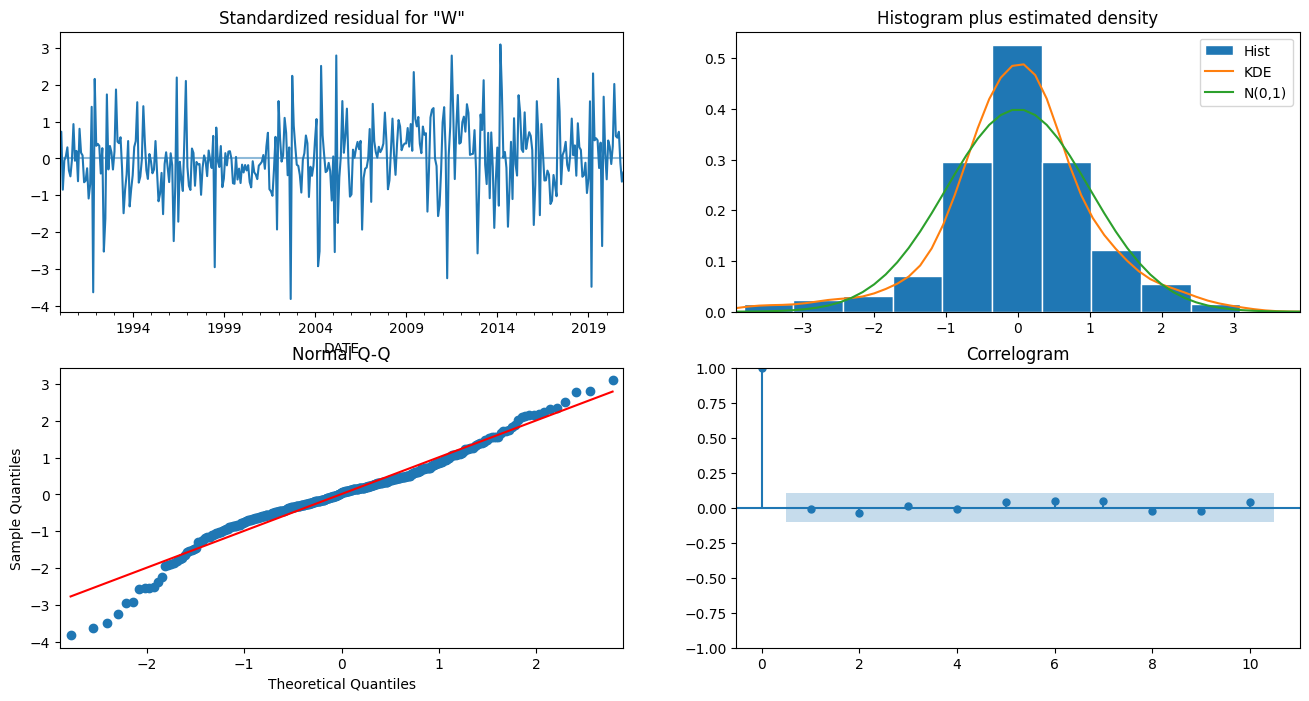

In [114]:
_ = water_model.plot_diagnostics()

"For an ideal model, the residuals should be uncorrelated white Gaussian noise centered on zero." - James Fulton in the DataCamp course "ARIMA Models in Python".

To determine how we can improve our models, we should observe a few things:
1. The Ljung-Box test tells us whether the residuals from the model are correlated. The null hypothesis states that the residuals are uncorrelated. In other words, are the residuals white noises? Based on all the time series above, it seems like all of them have a P-value greater than 0.05, thus the residuals for all the models above are uncorrelated.
2. The Jarque-Bera test tells us whether the residuals follow a normal distribution. The null hypothesis states that the residuals are normally distributed. Unfortunately, all the time series models above have P-value less than 0.05, which means the residuals are not normally distributed. 
3. By looking at the standard diagnostics plots, we can see that while the standardised residual and correlogram for all 3 time series looks mostly fine except for electricity with normal differencing, with no obvious structures or patterns for all the standardised residual and mostly no significant correlated residual in the correlogram, the histogram and Q-Q plot do not seem to show normality.

Seems like all the residuals are not normal, and the electricity, both normal and seasonal differenced, have significant autocorrelation among the residuals, what if I try to do some hyperparameters tuning by looking for the smallest AIC and BIC scores? AIC "is a mathematical method for evaluating how well a model fits the data it was generated from" while also penalising more complex models (Bevans, R. (2023)). BIC is similar but in a way that penalises complex models more strictly. As a rule of thumb, lower AIC score can produce better predictive models while lower BIC score can produce better explanatory values. So, I will try to find the lowest AIC value parameters.

In [115]:
# iterate over a range of p and q and then decide which parameter is the best for each time series
def fine_tuning(df_train, df_test, exog_train=None, exog_test=None):

    scores = []
    for p in range(4):
        for q in range(4):

            result = ARIMA(df_train, order=(p, 0, q), exog=exog_train).fit()
            y_pred = result.forecast(len(df_test), exog=exog_test)
            mae = mean_absolute_error(df_test, y_pred)
            scores.append([p, q, result.aic, result.bic, mae])


    scores_df = pd.DataFrame(scores, columns=['p', 'q', 'AIC', 'BIC', 'MAE'])

    # print the best parameters
    print(scores_df.sort_values('AIC'))

    # train the model with best parameters
    p, q = int(scores_df.sort_values('AIC').iloc[0].p), int(scores_df.sort_values('AIC').iloc[0].q)
    best_result = ARIMA(df_train, order=(p, 0, q), exog=exog_train).fit()
    print(best_result.summary())
    best_result.plot_diagnostics()
    plt.show()

    p  q          AIC          BIC       MAE
9   2  1  2002.478209  2022.072679  3.340844
13  3  1  2003.438346  2026.951709  3.355783
10  2  2  2003.613723  2027.127086  3.355425
7   1  3  2004.144709  2027.658072  3.313420
11  2  3  2005.102661  2032.534918  3.343287
14  3  2  2006.422653  2033.854910  3.342933
15  3  3  2006.684387  2038.035538  3.346598
6   1  2  2008.662183  2028.256652  3.474746
5   1  1  2010.854612  2026.530187  3.984723
8   2  0  2014.298290  2029.973865  4.273331
12  3  0  2014.566582  2034.161051  4.154919
4   1  0  2024.455446  2036.212127  4.541459
3   0  3  2046.687093  2066.281562  4.806779
2   0  2  2060.399005  2076.074580  4.933543
1   0  1  2109.491156  2121.247838  5.032064
0   0  0  2234.651565  2242.489352  5.142715
                               SARIMAX Results                                
Dep. Variable:                    Gas   No. Observations:                  372
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -996.23

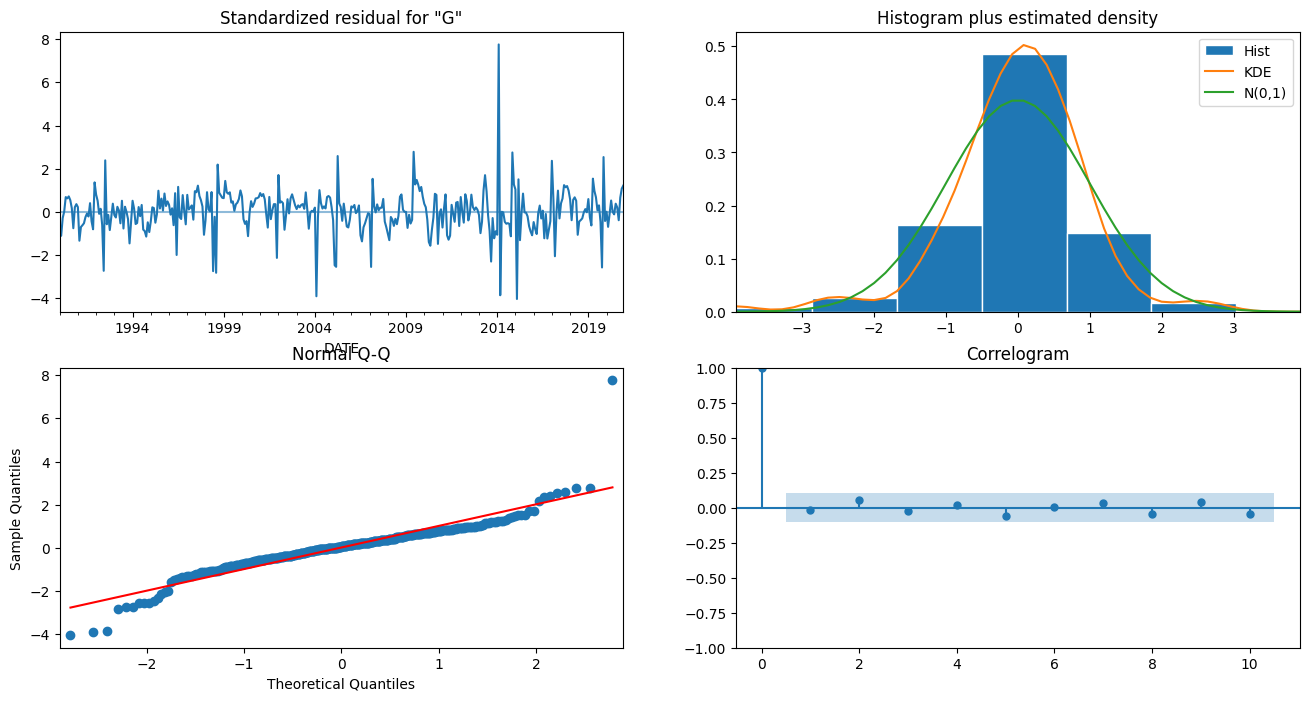

In [116]:
fine_tuning(gas_train, gas_test)

    p  q          AIC          BIC        MAE
11  2  3  3646.052699  3673.466113  37.913479
14  3  2  3650.310659  3677.724074  37.256098
10  2  2  3650.386522  3673.883734  37.920811
15  3  3  3659.640415  3690.970031  36.446624
13  3  1  3750.529062  3774.026275  68.174485
9   2  1  3762.356554  3781.937564  68.450661
12  3  0  3821.480060  3841.061070  59.952996
3   0  3  3971.539221  3991.120232  85.726396
7   1  3  3974.389713  3997.886925  86.070759
8   2  0  3978.430399  3994.095207  81.789721
6   1  2  4019.963042  4039.544052  87.481575
2   0  2  4048.652576  4064.317384  87.606722
1   0  1  4141.085061  4152.833668  87.347950
5   1  1  4141.726411  4157.391220  87.318171
4   1  0  4207.995967  4219.744573  88.304344
0   0  0  4264.236235  4272.068640  89.002448
                                  SARIMAX Results                                  
Dep. Variable:     Electricity_normal_diff   No. Observations:                  371
Model:                      ARIMA(2, 0, 3)   Log L

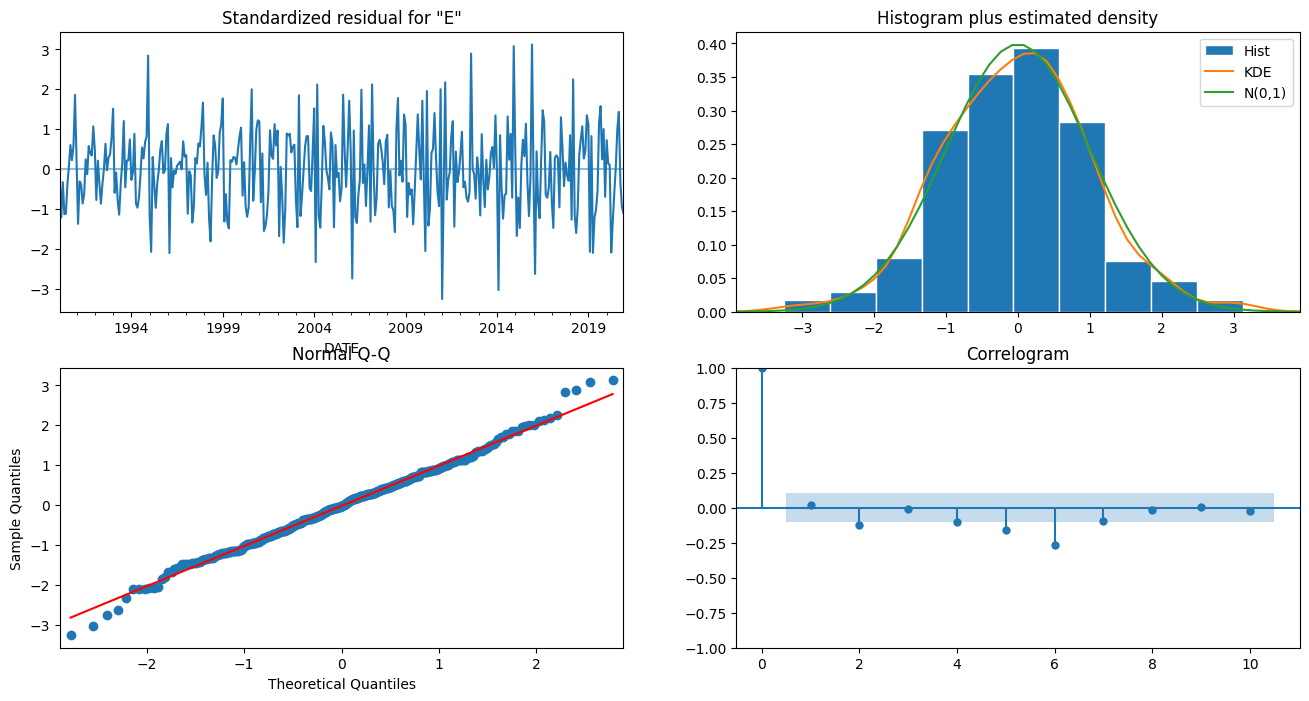

In [117]:
fine_tuning(electricity_nd_train, electricity_nd_test)

    p  q          AIC          BIC        MAE
15  3  3  3366.913111  3397.979690  45.350588
10  2  2  3386.377306  3409.677240  44.191716
11  2  3  3387.834618  3415.017875  44.266745
14  3  2  3388.083271  3415.266527  44.239550
13  3  1  3388.253480  3411.553415  43.795706
6   1  2  3391.047760  3410.464372  44.046522
5   1  1  3391.776334  3407.309623  43.745733
9   2  1  3392.495860  3411.912472  43.895961
3   0  3  3395.429324  3414.845936  44.613137
7   1  3  3398.518652  3421.818587  45.318728
2   0  2  3398.671945  3414.205235  44.836180
8   2  0  3430.978685  3446.511974  43.791779
12  3  0  3432.329471  3451.746083  43.909260
1   0  1  3447.670622  3459.320590  44.226586
4   1  0  3464.708922  3476.358889  44.703067
0   0  0  3475.362077  3483.128722  44.655165
                                  SARIMAX Results                                  
Dep. Variable:     Electricity_season_diff   No. Observations:                  359
Model:                      ARIMA(3, 0, 3)   Log L

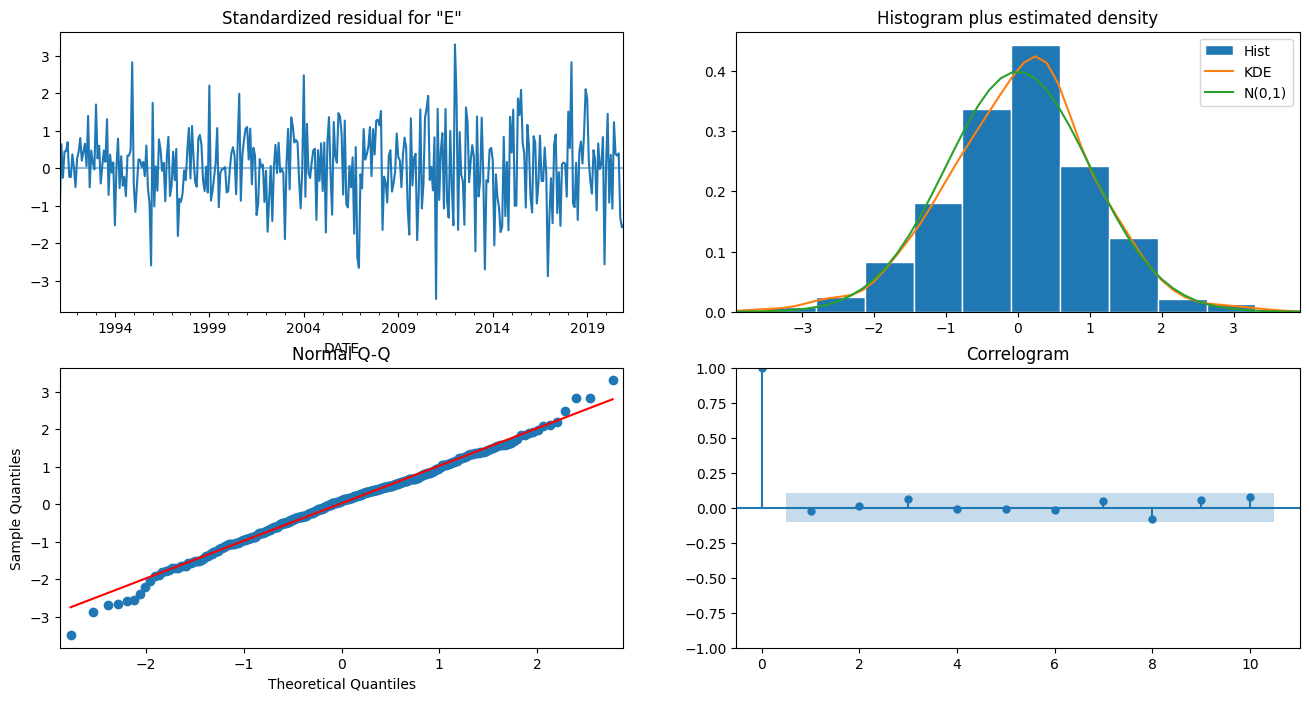

In [118]:
fine_tuning(electricity_sd_train, electricity_sd_test)

    p  q          AIC          BIC        MAE
9   2  1  4449.626362  4473.139725  84.049015
10  2  2  4449.675150  4477.107407  85.991719
13  3  1  4449.725407  4477.157664  85.774183
11  2  3  4451.675367  4483.026518  85.944985
5   1  1  4451.864917  4471.459386  94.694720
14  3  2  4452.272713  4483.623863  84.313634
6   1  2  4452.946067  4476.459430  94.497226
15  3  3  4453.111110  4488.381155  85.627006
8   2  0  4453.312408  4472.906877  95.499577
12  3  0  4453.951980  4477.465343  95.342078
7   1  3  4454.124206  4481.556463  92.022131
4   1  0  4457.116602  4472.792177  95.355036
3   0  3  4471.774643  4495.288006  96.018862
2   0  2  4488.893001  4508.487470  95.549517
1   0  1  4524.998222  4540.673797  95.262349
0   0  0  4648.724088  4660.480769  94.075448
                               SARIMAX Results                                
Dep. Variable:                  Water   No. Observations:                  372
Model:                 ARIMA(2, 0, 1)   Log Likelihood      

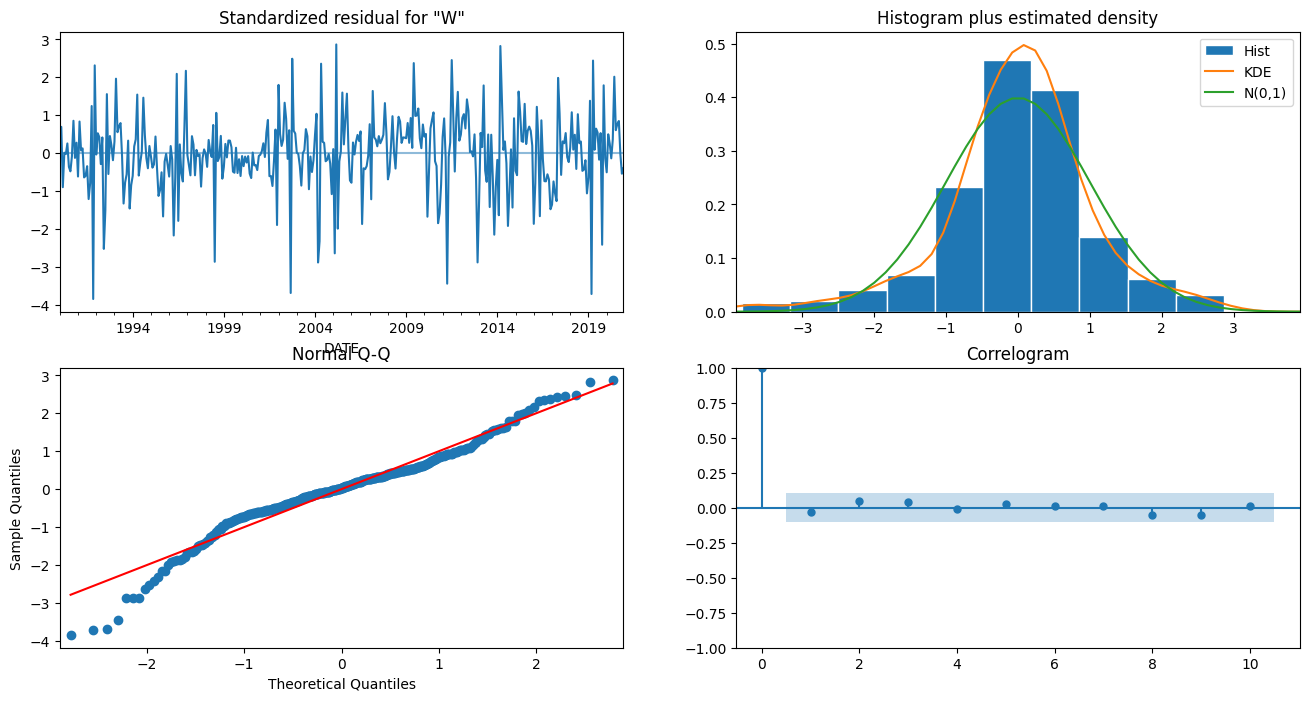

In [119]:
fine_tuning(water_train, water_test, gas_train, gas_test)

Seems like for Gas, the best parameter is ARMA(2, 1), for Electricity with normal differencing, the best parameter is ARMA(2, 3), for Electricity with seasonal differencing the best parameter is ARMA(3, 3) and for Water, the best parameter is ARMA(2, 1). Even then, the only improvement we can observe is that for the Electricity with normal differencing, the residuals are finally normal, with Electricity with seasonal differencing almost being normal with P-value of 0.04. Other than that, the residuals for all 3 time series are still not normal. At this point, maybe the original data themselves are not normal?

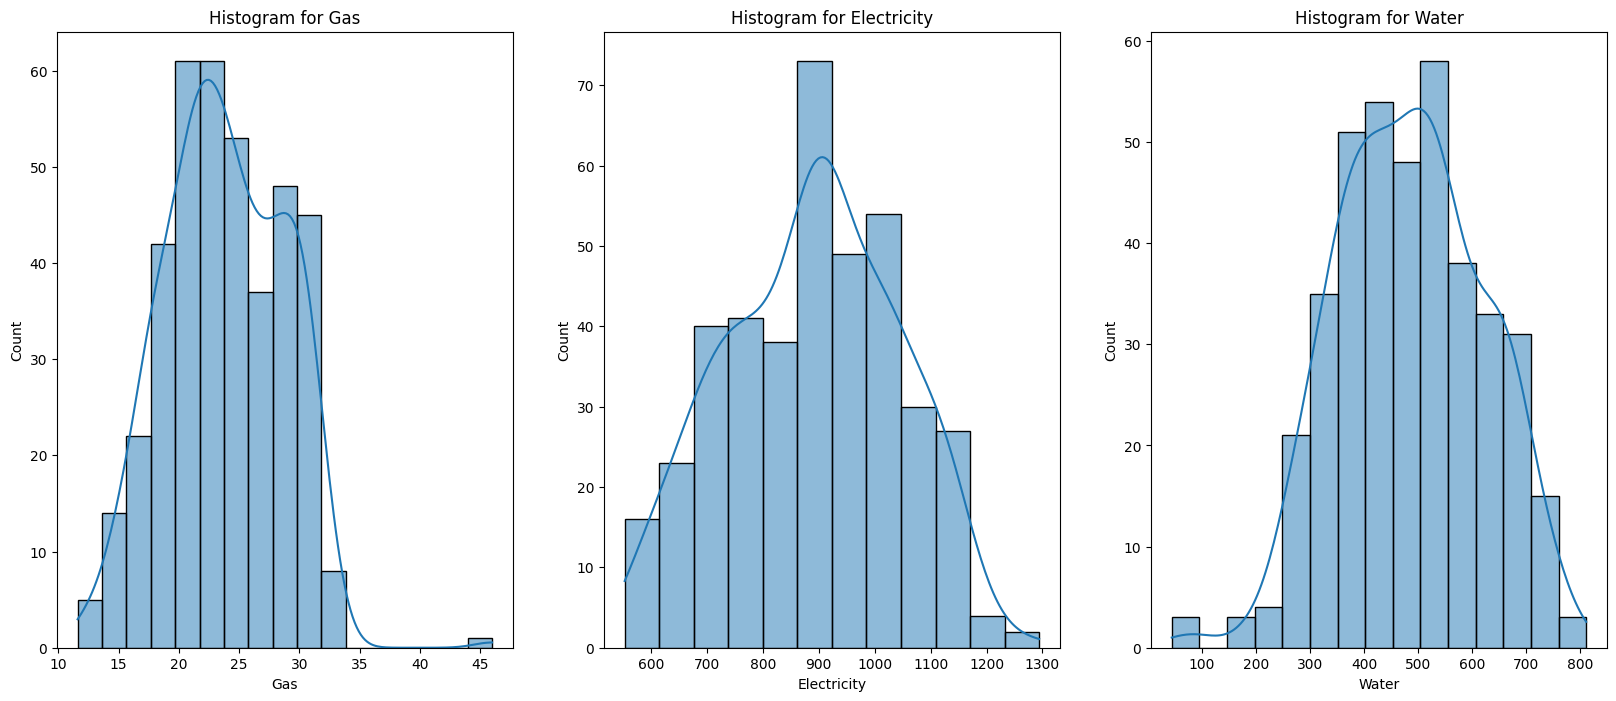

In [120]:
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(20)

for i, col in enumerate(new_energy_df.columns):
    sns.histplot(data=new_energy_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram for {col}')

plt.show()

Certainly, they are not normal even by looking at the distribution. What's worse is that there is no way I can transform the data to be normal. I should simply move on and see how our current model will forecast.

In [121]:
def make_forecast(df, df_train, df_test, order, exo_tr=None, exo_te=None):
    result = ARIMA(df_train, order=order, exog=exo_tr).fit()
    forecast = result.forecast(len(df_test), exog=exo_te)
    
    df_short = df.loc['2013':]
    plt.plot(df_short.index, df_short, label='Observed')
    plt.plot(forecast.index, forecast, color='red', label='Predicted')
    plt.show()

def make_forcast_w_reverse_diff(df_train, df_test, order, col):
    result = ARIMA(df_train, order=order).fit()
    forecast = result.get_forecast(len(df_test))

    mean_forecast = np.cumsum(forecast.predicted_mean) + new_energy_df.loc[str(training_cutoff)][col]
    df_short = new_energy_df[col].loc['2013':]
    plt.plot(df_short.index, df_short, label='Observed')
    plt.plot(df_test.index, mean_forecast, color='red', label='Predicted')
    plt.show()

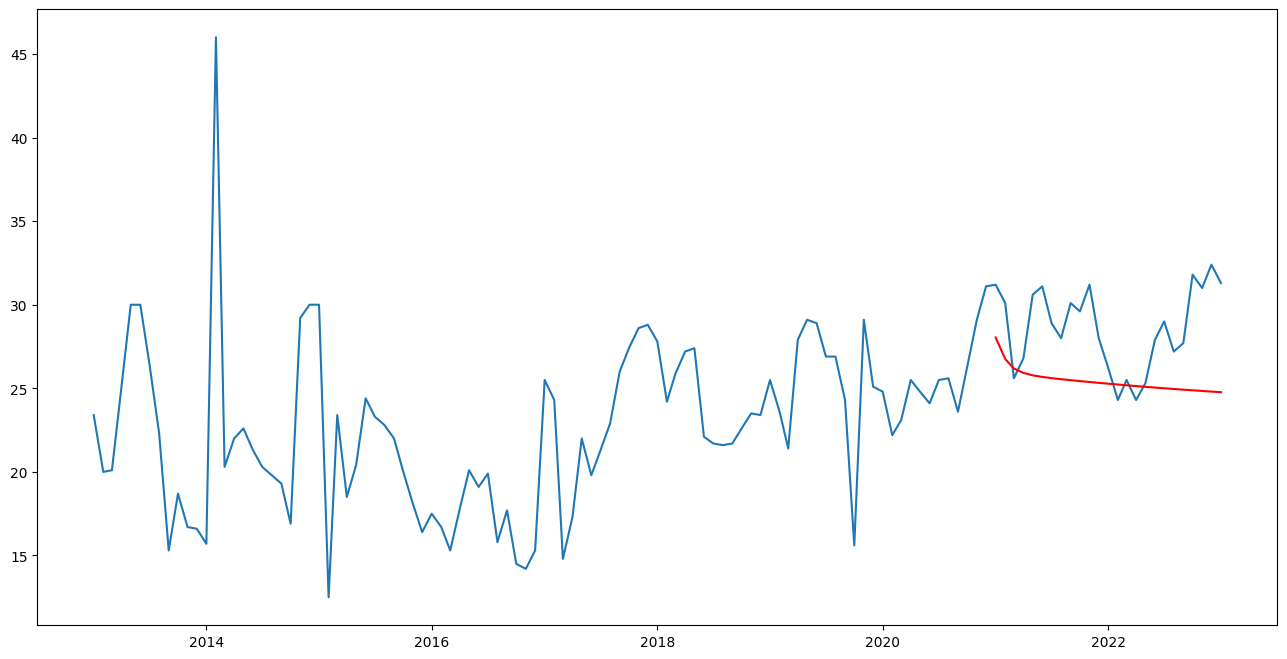

In [122]:
make_forecast(gas_df, gas_train, gas_test, (2, 0, 1))

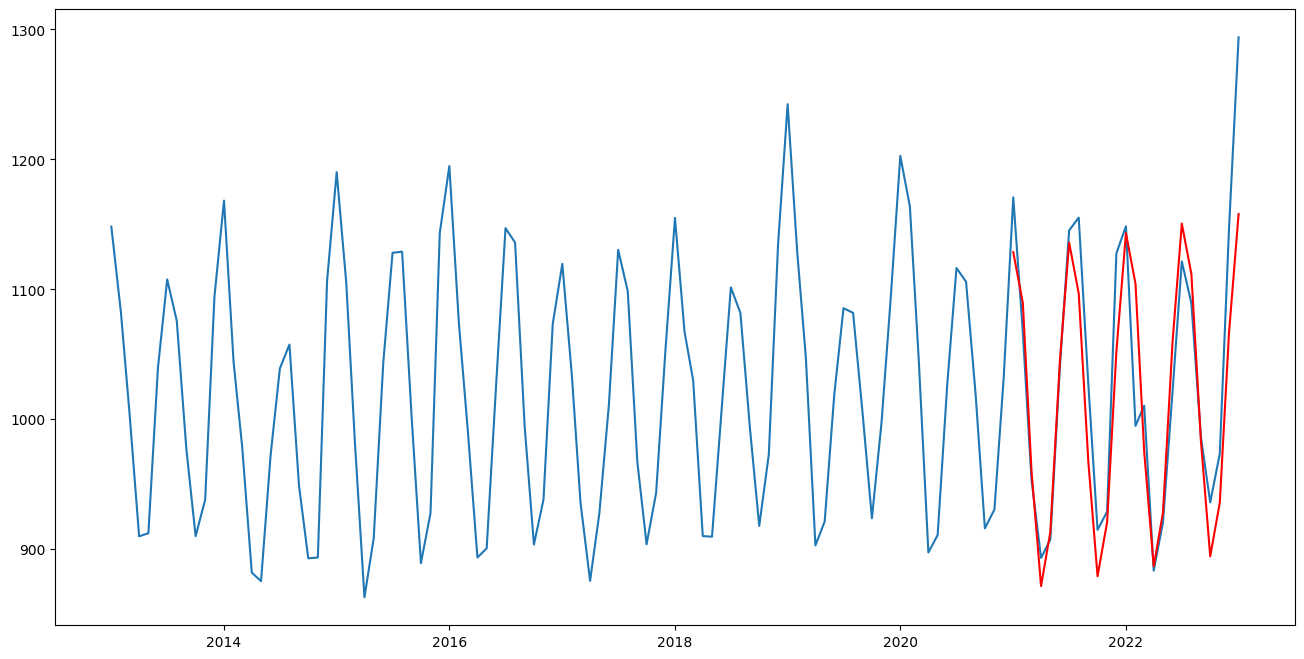

In [123]:
make_forcast_w_reverse_diff(electricity_nd_train, electricity_nd_test, (2, 0, 3), 'Electricity')

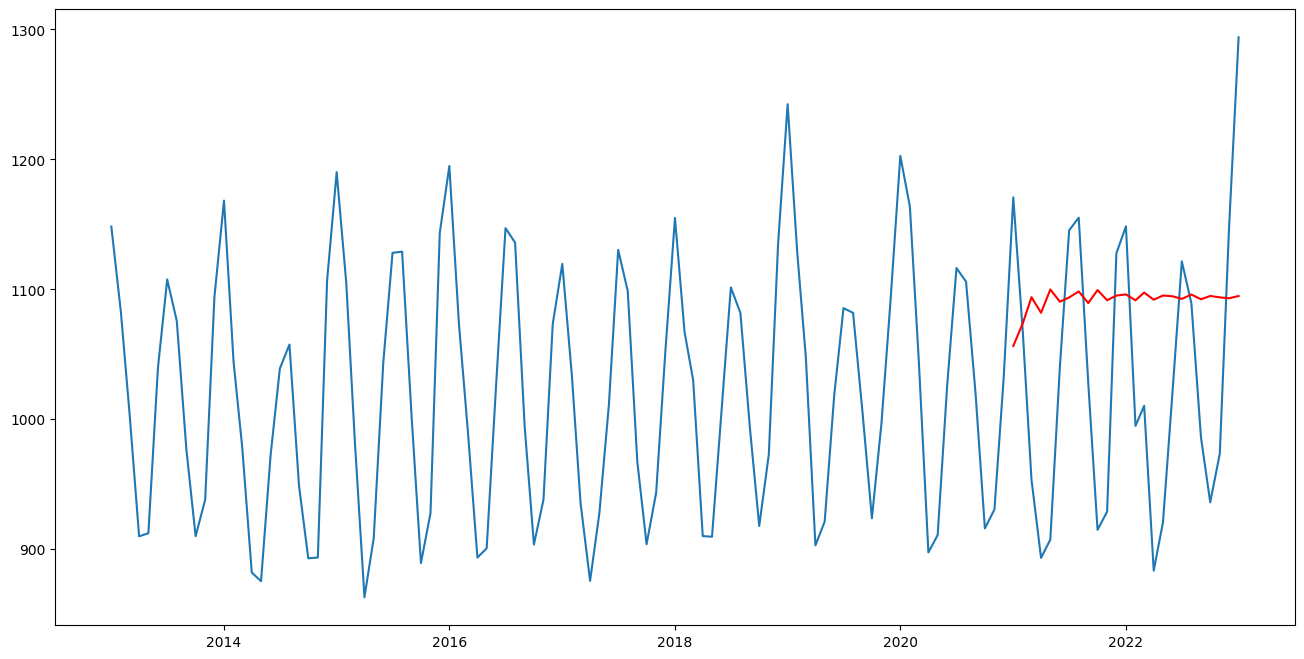

In [124]:
make_forcast_w_reverse_diff(electricity_sd_train, electricity_sd_test, (3, 0, 3), 'Electricity')

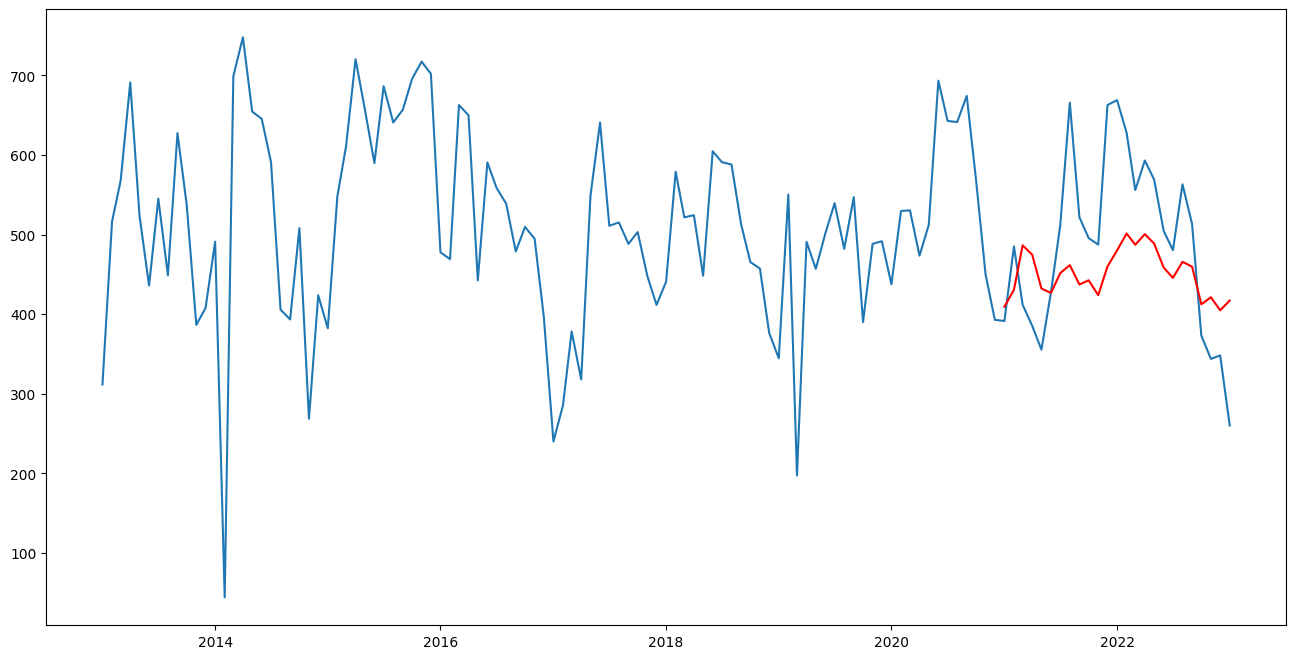

In [125]:
make_forecast(water_df, water_train, water_test, (2, 0, 1), gas_train, gas_test)

By looking at the forecast, I can see that the prediction actually went well except for the gas. The electricity with normal differencing predicted better than I expected despite the fact that the correlogram shows some correlated residuals. The correlated residual is to be expected as time series with obvious seasonality like the Electricity consumption tend to have strong autocorrelation when using ARIMA. The Electricity with normal differencing shows the seasonality pretty well, and we can also observe the slow trend upwards, although the trend actually plateua from the early-mid 2010s onwards. The only downside is having correlated residual, which means there are some lost of information. Unfortunately, when using ARIMA for Electricity with seasonality differenced, not only does it fail to predict the seasonality well enough, the spikes are way too small, it should be obvious as ARIMA currently cannot predict seasonality without any info. While Water, I can clearly see some accurate spikes and dips, but they are underestimated. 

But for Gas, the prediction seems to went the wrong way, and there's no spikes either. I suspect that Gas may still require the exogenous variable from Water to get more accurate predictions. Let me just do a quick hypertuning and then do the prediction for Gas with Water exogenous variable.

    p  q          AIC          BIC       MAE
14  3  2  1947.631036  1978.982186  3.532707
7   1  3  1947.814068  1975.246325  3.708115
11  2  3  1947.948523  1979.299674  3.606703
5   1  1  1947.971769  1967.566238  4.524451
8   2  0  1948.471812  1968.066281  4.592164
6   1  2  1949.376778  1972.890141  4.392620
9   2  1  1949.743474  1973.256837  4.512756
12  3  0  1950.160183  1973.673546  4.543139
4   1  0  1951.282895  1966.958471  4.734346
10  2  2  1951.407548  1978.839805  4.443705
15  3  3  1952.146354  1987.416399  4.161365
13  3  1  1952.399470  1979.831727  4.570730
3   0  3  1972.471160  1995.984523  4.997845
2   0  2  1985.025738  2004.620208  5.020774
1   0  1  2035.285133  2050.960708  5.101560
0   0  0  2172.863853  2184.620535  5.192924
                               SARIMAX Results                                
Dep. Variable:                    Gas   No. Observations:                  372
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -965.81

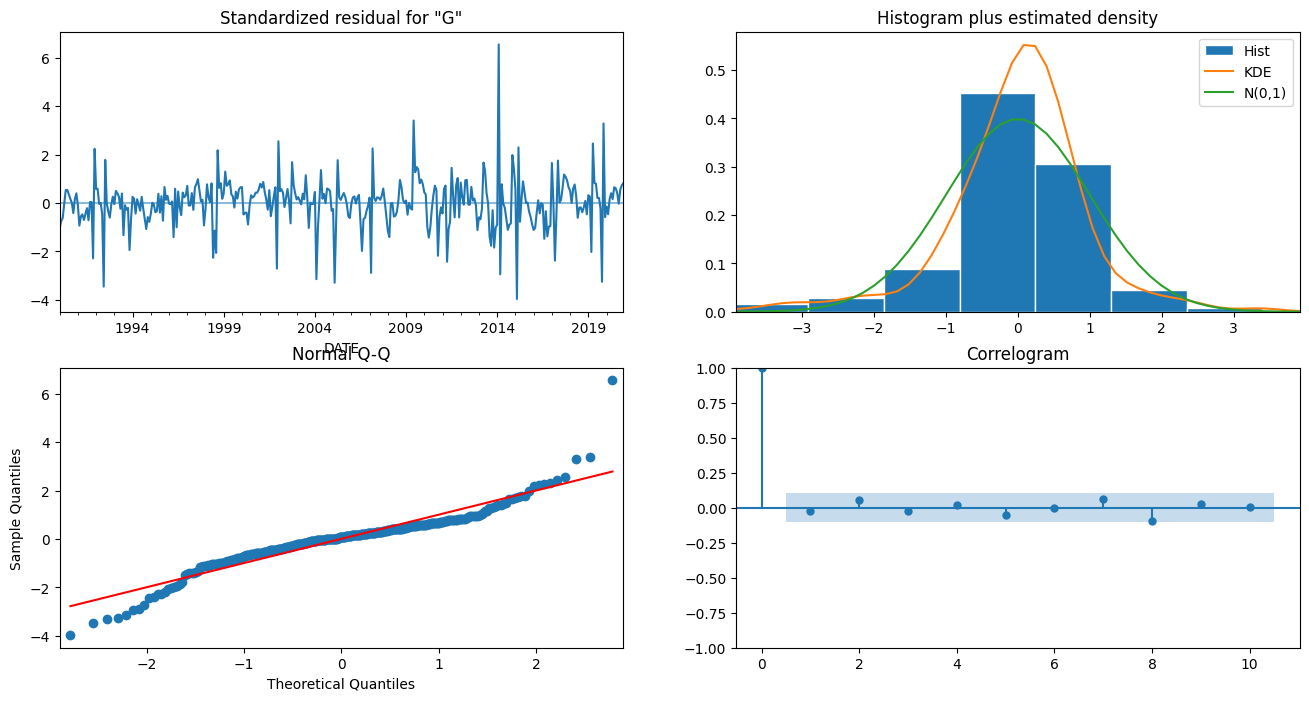

In [126]:
fine_tuning(gas_train, gas_test, water_train, water_test)

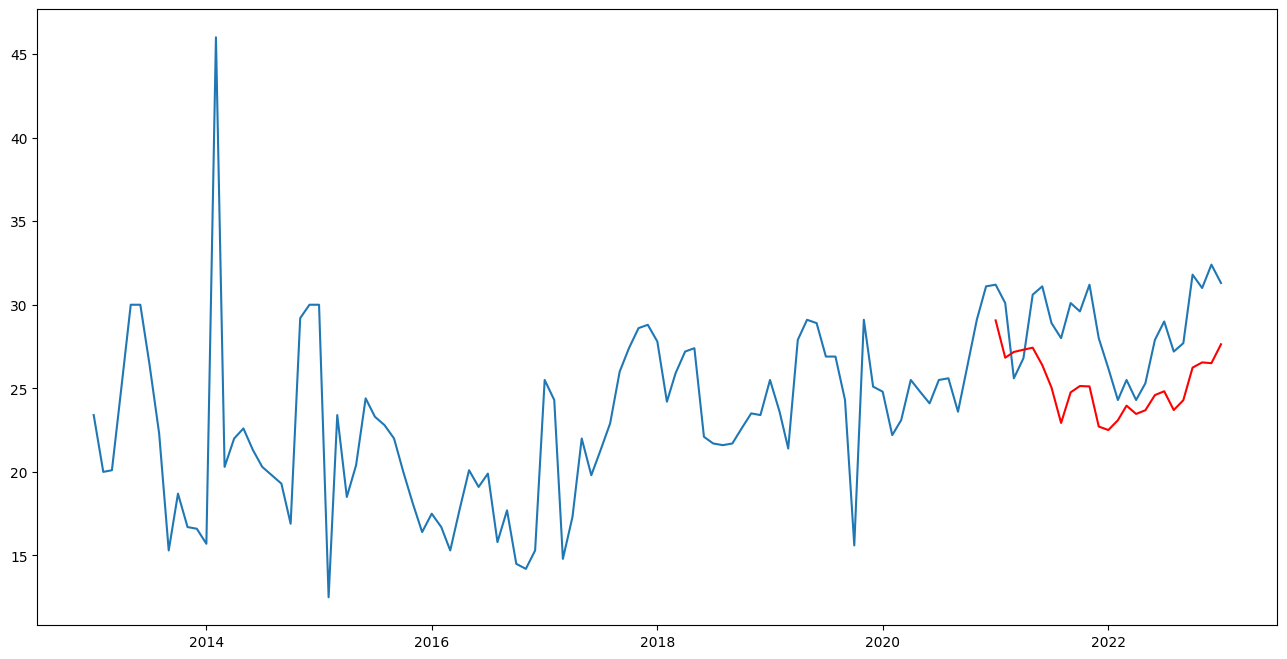

In [143]:
make_forecast(gas_df, gas_train, gas_test, (3, 0, 2), water_train, water_test)

Seems like the added exogenous variable create the spikes and dips which is mostly align with the actual spikes and dips, which makes the forecasting looks accurate. However, the trend seems to be similar to the original Gas forecast I made without any exogenous variable, which is that it seems to be going slightly downwards overall rather than upwards. So in conclusion, despite Water do not granger cause Gas, there still seem to be some kind of bi-directional relationship afterall.

Now we shall try the SARIMA algorithm.

In [128]:
# clone the original dataset
station_energy_df2 = new_energy_df.copy(deep=True)
station_energy_df2['Electricity'] = station_energy_df2['Electricity'].diff(1)
# station_energy_df2['Electricity'] = station_energy_df2['Electricity'].diff(12)

This time, we just retain the seasonality component of the electricity time series simply because the seasonality component is necessary for time series like electricity where there is obvious seasonality, and for SARIMA model.

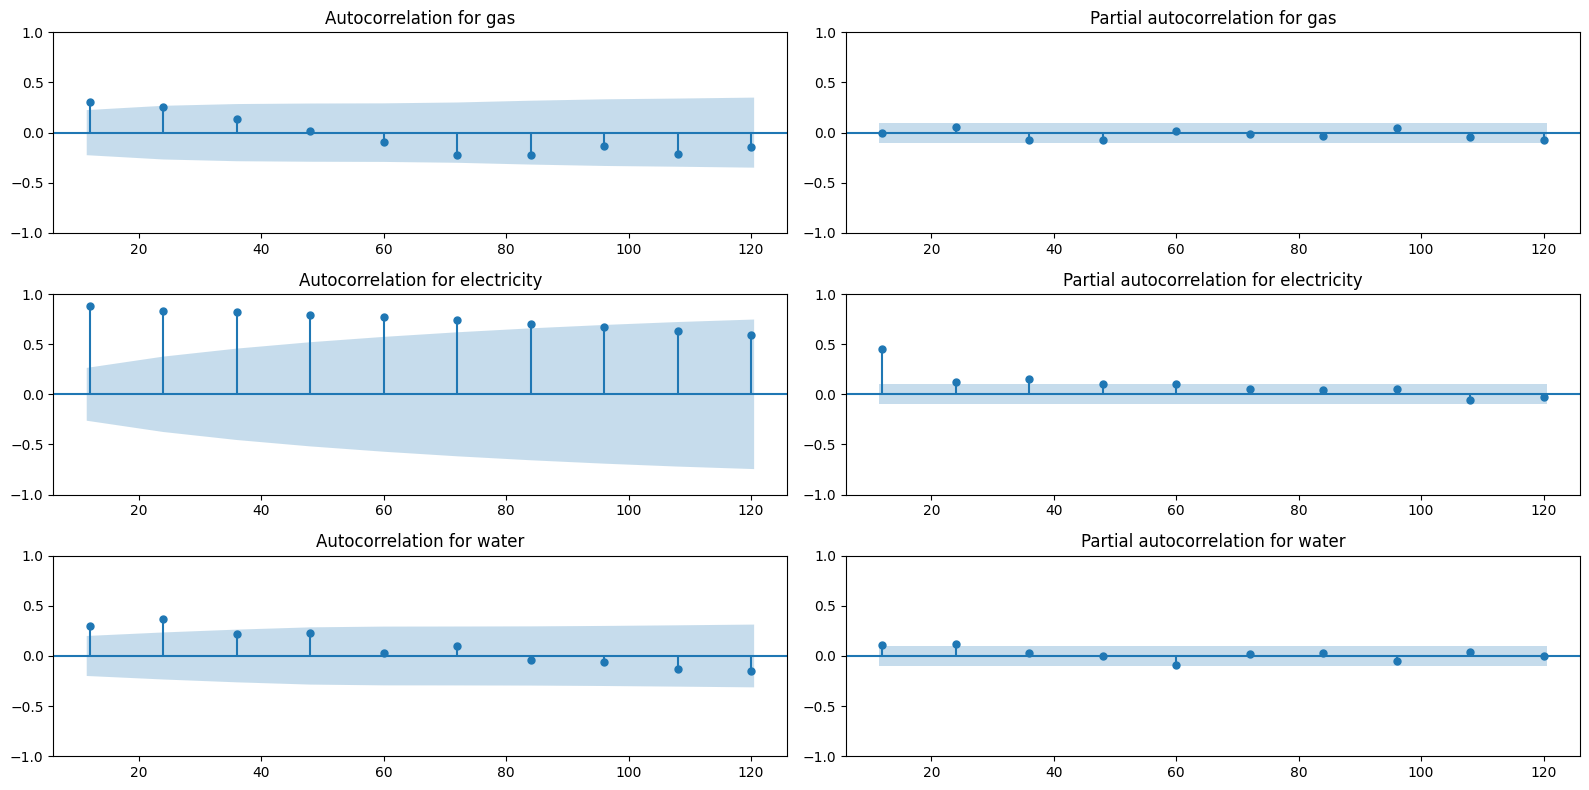

In [129]:
# a variable that allows me to easily change how many points I want to see
num_of_lag = 10
lag_list = [x for x in range(12, (num_of_lag * 12) + 1, 12)]

fig, axes = plt.subplots(3, 2)

plot_acf(station_energy_df2['Gas'], alpha=0.05, title=f'Autocorrelation for gas', zero=False, ax=axes[0, 0], lags=lag_list)
plot_pacf(station_energy_df2['Gas'], alpha=0.05, title=f'Partial autocorrelation for gas', zero=False, ax=axes[0, 1], lags=lag_list)
plot_acf(station_energy_df2['Electricity'].dropna(), alpha=0.05, title=f'Autocorrelation for electricity', zero=False, ax=axes[1, 0], lags=lag_list)
plot_pacf(station_energy_df2['Electricity'].dropna(), alpha=0.05, title=f'Partial autocorrelation for electricity', zero=False, ax=axes[1, 1], lags=lag_list)
plot_acf(station_energy_df2['Water'], alpha=0.05, title=f'Autocorrelation for water', zero=False, ax=axes[2, 0], lags=lag_list)
plot_pacf(station_energy_df2['Water'], alpha=0.05, title=f'Partial autocorrelation for water', zero=False, ax=axes[2, 1], lags=lag_list)
plt.tight_layout()

plt.show()

So now is time to do SARIMA -- is basically Seasonal ARIMA which is an extension to the ARIMA model I used but it can take into account the seasonal component. Gas and Water unfortunately will be pretty useless in SARIMA as they do not display strong seasonality, they can just use ARIMA instead, no need the seasonality component. I can do a quick test by searching through the best hyperparameters, I expect that the best hyperparameters for P and Q will be 0.

In [130]:
def fine_tuning2(df_train, df_test, order, exog_train=None, exog_test=None):

    scores = []
    for p in range(4):
        for q in range(4):

            try:
                result = SARIMAX(df_train, order=order, seasonal_order=(p, 0, q, 12), exog=exog_train).fit(disp=False)
                y_pred = result.forecast(len(df_test), exog=exog_test)
                mae = mean_absolute_error(df_test, y_pred)
                scores.append([p, q, result.aic, result.bic, mae])
            except:
                print(f'Error ocurred at p={p}, q={q}')


    scores_df = pd.DataFrame(scores, columns=['p', 'q', 'AIC', 'BIC', 'MAE'])

    # print the best parameters
    print(scores_df.sort_values('AIC'))

    # train the model with best parameters
    try:
        p, q = int(scores_df.sort_values('AIC').iloc[0].p), int(scores_df.sort_values('AIC').iloc[0].q)
        # P, Q = int(scores_df.sort_values('AIC').iloc[0].P), int(scores_df.sort_values('AIC').iloc[0].Q)
        best_result = SARIMAX(df_train, order=order, seasonal_order=(p, 0, q, 12), exog=exog_train).fit(disp=False)
        print(best_result.summary())
        best_result.plot_diagnostics()
        plt.show()
    except:
        print(f'Error: the best hyperparameters caused an error on fitting')

Error ocurred at p=2, q=2
    p  q          AIC          BIC         MAE
3   0  3    20.000000    59.188939  426.866126
0   0  0  1990.012760  2017.445017    3.937979
8   2  0  2015.358242  2050.628286    3.394375
5   1  1  2017.981043  2053.251088    1.485798
11  3  0  2018.124417  2057.313355    2.976101
13  3  2  2019.869417  2066.896144    2.285820
9   2  1  2020.384731  2059.573670    1.417735
6   1  2  2021.964334  2061.153273    1.512035
12  3  1  2022.335119  2065.442951    2.525847
10  2  3  2023.787176  2070.813902    2.143338
14  3  3  2024.872464  2075.818084    2.234564
1   0  1  2025.063195  2056.414346    1.426064
2   0  2  2030.657110  2065.927155    1.485227
7   1  3  2034.191800  2077.299633    1.421267
4   1  0  2036.854409  2068.205560    1.528158
                                         SARIMAX Results                                          
Dep. Variable:                                        Gas   No. Observations:                  372
Model:             SARIM

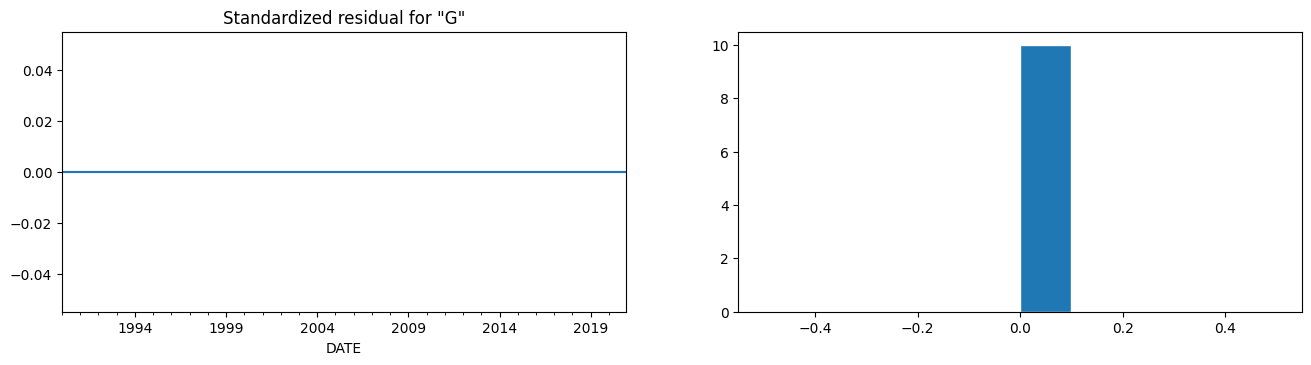

In [131]:
fine_tuning2(gas_train, gas_test, (3, 0, 2), water_train, water_test)

Error ocurred at p=3, q=2
    p  q          AIC          BIC        MAE
2   0  2  4454.443459  4481.875716  75.653581
0   0  0  4456.010434  4475.604903  80.682781
8   2  0  4456.162352  4483.594609  75.136511
4   1  0  4456.210909  4479.724272  80.473739
12  3  0  4456.734088  4488.085239  75.137398
1   0  1  4456.800626  4480.313989  80.070965
5   1  1  4459.073911  4486.506168  77.392347
7   1  3  4460.096177  4495.366221  75.102304
3   0  3  4462.057182  4493.408333  74.068110
6   1  2  4464.211006  4495.562157  79.045438
9   2  1  4464.635042  4495.986193  78.500879
13  3  1  4465.139247  4500.409292  75.702737
10  2  2  4470.869627  4506.139672  74.292109
11  2  3  4475.660485  4514.849424  80.793933
14  3  3  4484.726221  4527.834054  80.129891
                                        SARIMAX Results                                        
Dep. Variable:                                   Water   No. Observations:                  372
Model:             SARIMAX(2, 0, 1)x(0, 0, [1,

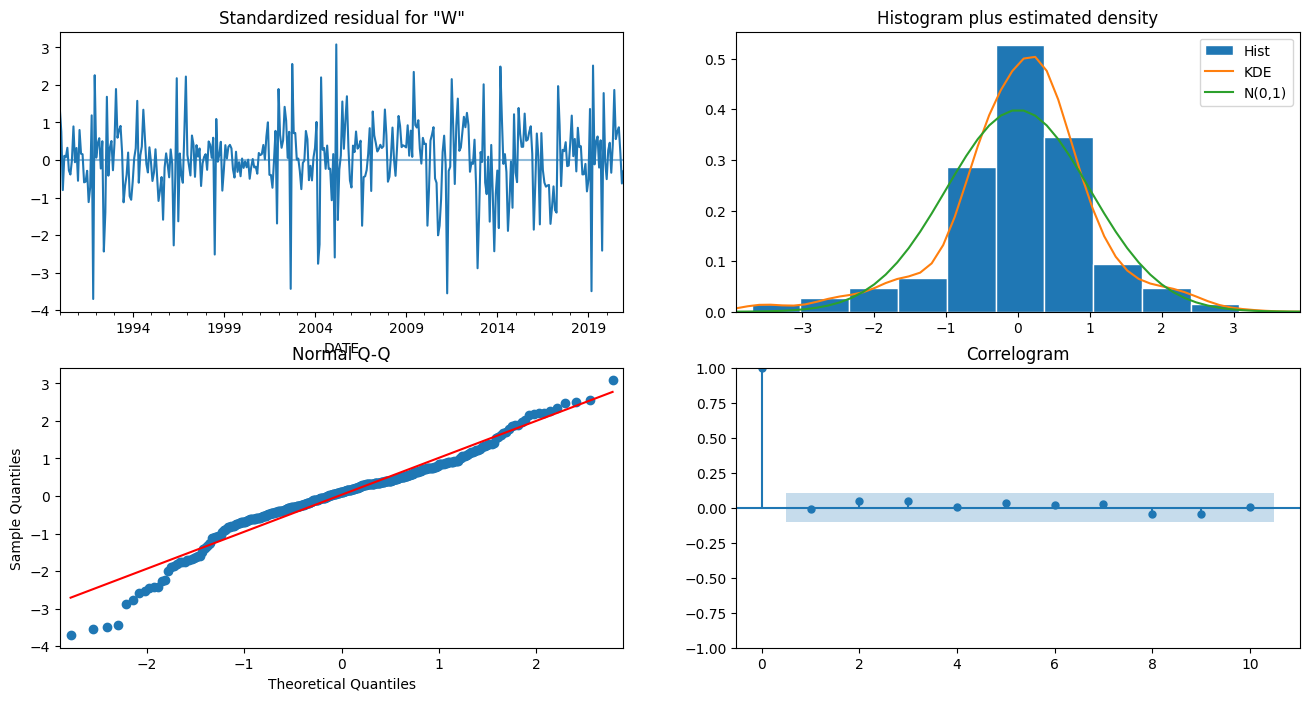

In [132]:
fine_tuning2(water_train, water_test, (2, 0, 1), gas_train, gas_test)

Well, I was half right. For Gas, it looks like the best model is P=0 and Q=3, but the scores look rather fishy. It actually resulted an error when trying to plot diagnostics. Even the summary seems to show 0 and infinity, so something is wrong. So the next best hyperparameter is just P=0 and Q=0, which is just no seasonality at all. But for Water, I was kind of wrong. The best hyperparameter appears to be P=0 and Q=2, which suggests the model still needs seasonal error as well. But notice the second best hyperparameter is P=0 and Q=0, which means even having no seasonal components can be almost as good as having it.

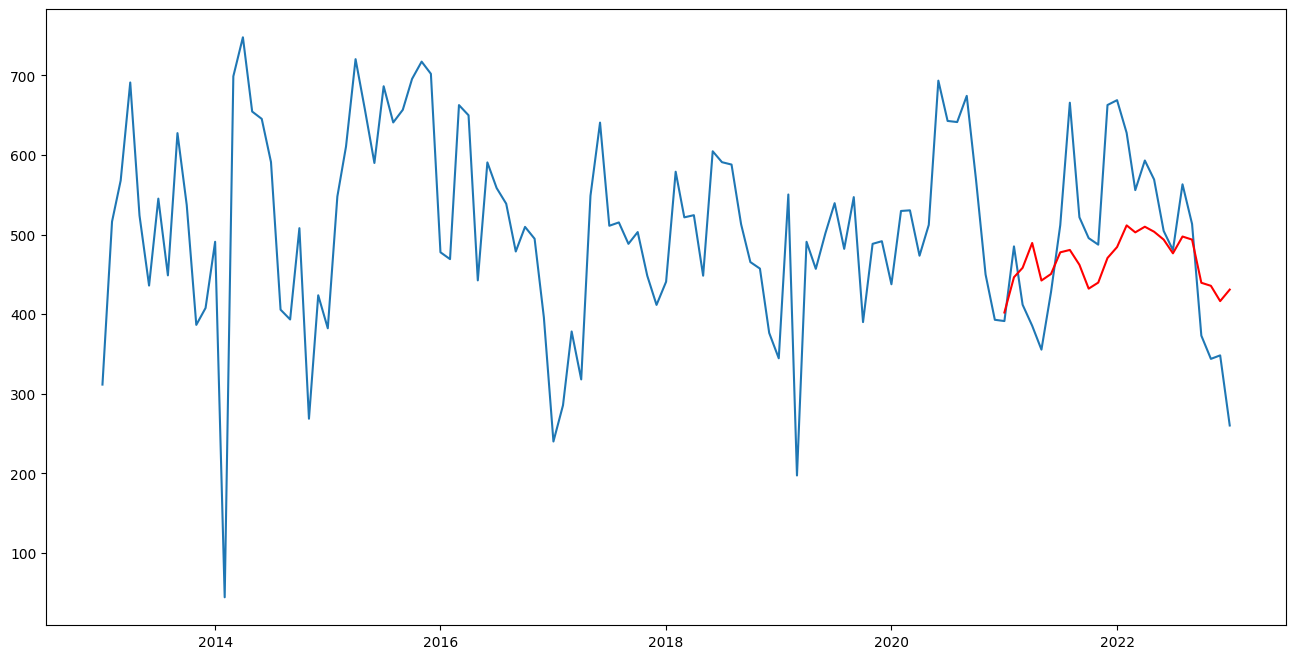

In [133]:
result = SARIMAX(water_train, order=(2, 0, 1), seasonal_order=(0, 0, 2, 12), exog=gas_train).fit(disp=False)
forecast = result.forecast(len(electricity_nd_test), exog=gas_test)

df_short = new_energy_df['Water'].loc['2013':]
plt.plot(df_short.index, df_short, label='Observed')
plt.plot(forecast.index, forecast, color='red', label='Predicted')
plt.show()

The forecast looks more or less similar to having no seasonality component at all. So if I want a simpler model, ARIMA would still work for water consumption forecasting.

Now time for our main goal for SARIMA: electricity.

    p  q          AIC          BIC        MAE
9   2  1  3430.431803  3465.677622  32.318758
5   1  1  3431.778165  3463.107782  31.931222
15  3  3  3435.144866  3482.139291  36.040127
11  2  3  3437.943174  3481.021397  31.971118
13  3  1  3446.832638  3485.994658  28.966993
14  3  2  3460.245029  3503.323252  38.127689
7   1  3  3462.156828  3501.318849  28.358971
12  3  0  3483.740303  3518.986122  35.155870
10  2  2  3498.139614  3537.301635  33.424084
8   2  0  3507.994541  3539.324157  39.318626
6   1  2  3515.421217  3550.667036  36.864592
2   0  2  3536.109495  3567.439112  38.526891
3   0  3  3538.493869  3573.739687  37.448295
4   1  0  3544.323635  3571.737050  41.025613
1   0  1  3557.865273  3585.278687  36.718018
0   0  0  3640.091292  3663.588505  37.445022
                                      SARIMAX Results                                       
Dep. Variable:              Electricity_normal_diff   No. Observations:                  371
Model:             SARIMAX(2, 0,

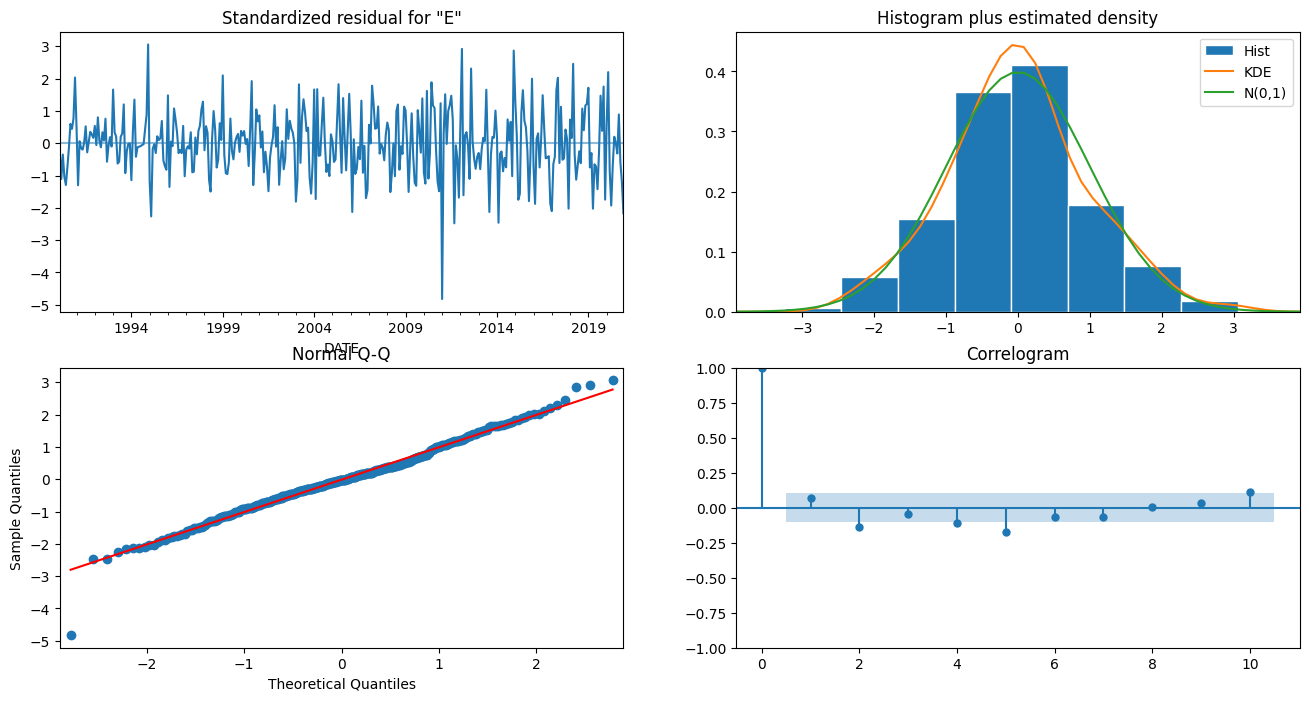

In [134]:
fine_tuning2(electricity_nd_train, electricity_nd_test, (2, 0, 3))

Let's plug the P and Q and forecast and see how it predicts.

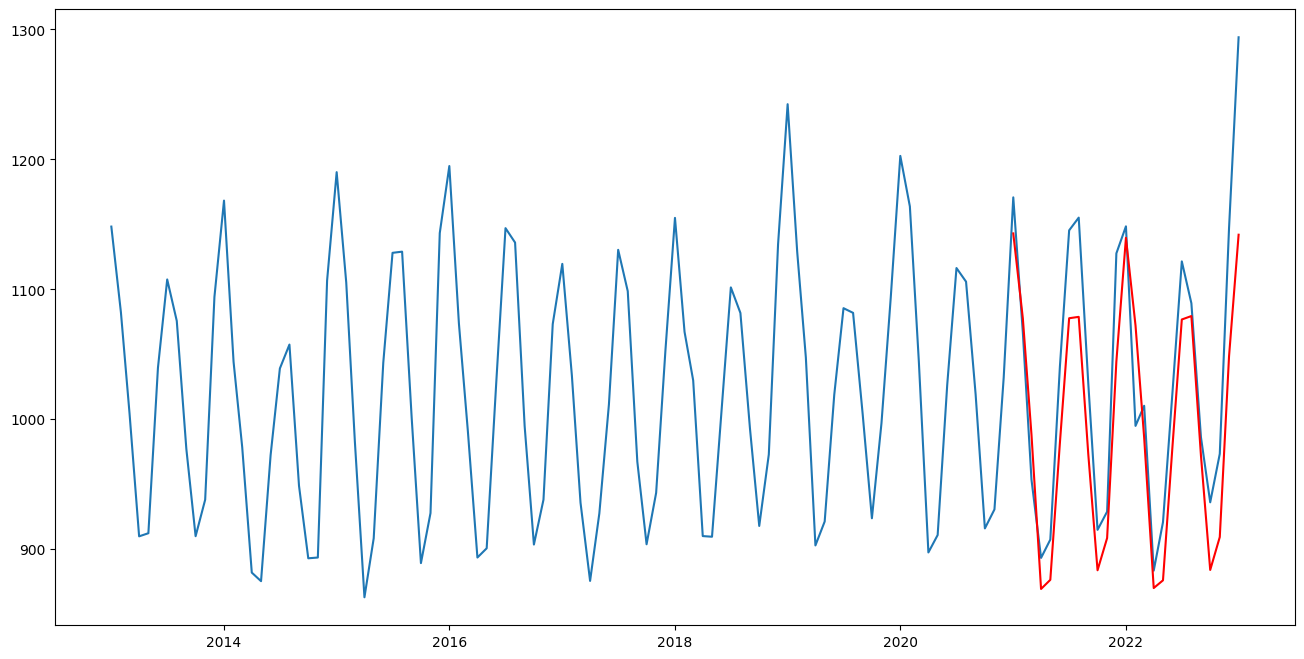

In [135]:
result = SARIMAX(electricity_nd_train, order=(2, 0, 3), seasonal_order=(2, 0, 1, 12)).fit(disp=False)
forecast = result.get_forecast(len(electricity_nd_test))

mean_forecast = np.cumsum(forecast.predicted_mean) + new_energy_df.loc[str(training_cutoff)]['Electricity']
df_short = new_energy_df['Electricity'].loc['2013':]
plt.plot(df_short.index, df_short, label='Observed')
plt.plot(electricity_nd_test.index, mean_forecast, color='red', label='Predicted')
plt.show()

It actually seems to predict much better than having ARIMA. Notice the spike in every half a year? They are not as high as the end or beginning of the year, which seems to be the case when looking back in time. So I would say using SARIMA for electricity is a huge success. When comparing the lowest AIC for electricity between SARIMA and ARIMA, SARIMA performed better.

Next, I will be trying out VAR, which is a multivariate time series algorithm to forecast multiple variable at the same time if they are "linked" in some way; in our case, the variables are Gas and Water variable. Despite the fact that granger causality test show that Gas granger cause Water, the other way is not true, hence a uni-directional way. But then just now when we do ARIMA, when we train Gas model without Water as an exogenous variable, it did not perform well. But by adding the exogenous variable, it performed better. Hence, instead of always relying on hypothesis test, I will just do my own experiment and see how it turns out.

In [136]:
# since we using gas and water, I will copy the original dataframe and drop electricity
gas_water = new_energy_df.copy(deep=True).drop(columns=['Electricity'])

# separate the training and test dataset
cut_off = date(2021, 1, 1)   
training_cutoff = cut_off - relativedelta(months=1)
gas_water_train, gas_water_test = gas_water.loc[:training_cutoff], gas_water.loc[cut_off:]

Now I will simply find the best hyperparameters by searching through a list of order values.

In [137]:
para = list(range(1, 11))
for i in para:
    model = VAR(gas_water_train)
    result = model.fit(i)
    print(f'Order {i} AIC: {result.aic}')

Order 1 AIC: 11.735907428509144
Order 2 AIC: 11.691943272515298
Order 3 AIC: 11.702306300351307
Order 4 AIC: 11.71280640102807
Order 5 AIC: 11.724105718530394
Order 6 AIC: 11.733773931797149
Order 7 AIC: 11.745730098795468
Order 8 AIC: 11.75741421975436
Order 9 AIC: 11.76693122807059
Order 10 AIC: 11.78226979398502


In [144]:
result = VAR(gas_water_train).fit(2)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Aug, 2023
Time:                     23:18:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.7977
Nobs:                     370.000    HQIC:                   11.7340
Log likelihood:          -3203.02    FPE:                    119605.
AIC:                      11.6919    Det(Omega_mle):         116436.
--------------------------------------------------------------------
Results for equation Gas
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            7.476566         1.592199            4.696           0.000
L1.Gas           0.537584         0.056901            9.448           0.000
L1.Water        -0.000159         0.001960           -0.081           0.935
L2.Gas

There seems to be a moderate negative correlation between the two variables residual, which may imply some information not being captured. But let's just try forecasting and see how it looks like.

In [145]:
pred = result.forecast(y=gas_water_train.values[-12:], steps=25)

forecast_df = pd.DataFrame(data=pred, index=gas_water_test.index, columns=['Gas forecast', 'Water forecast'])

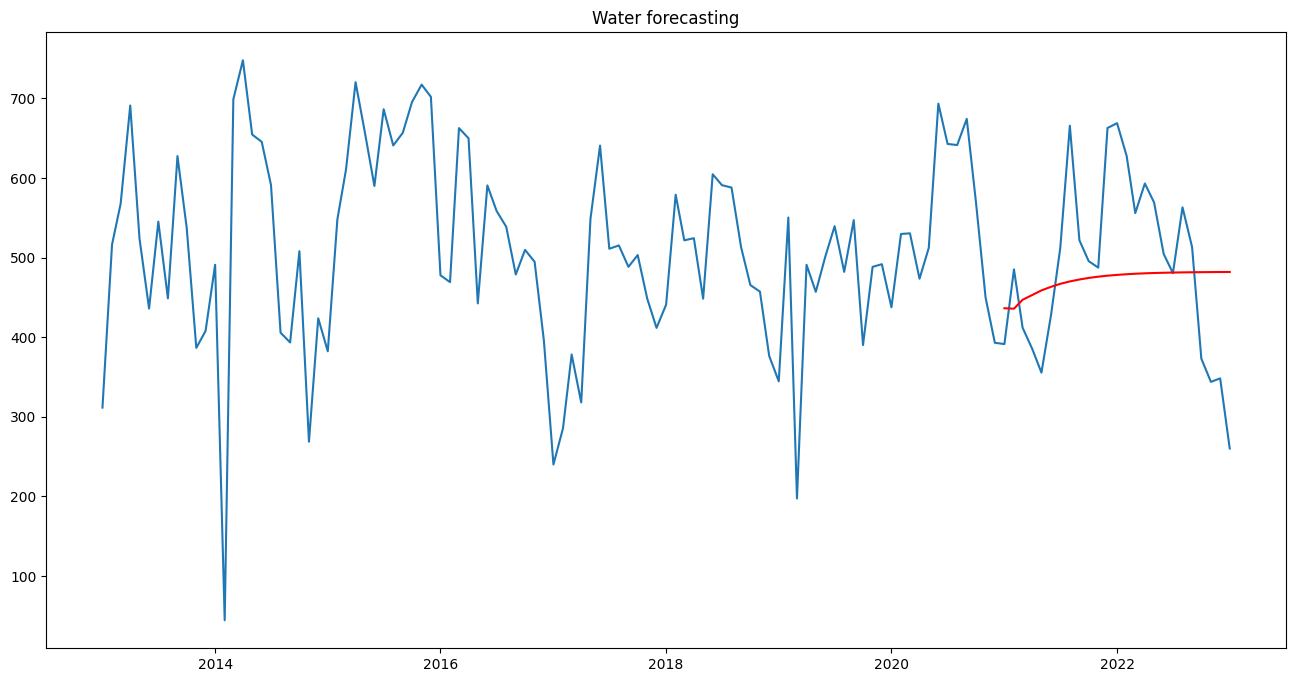

In [146]:
df_short = new_energy_df['Water'].loc['2013':]
plt.plot(df_short.index, df_short, label='Observed')
plt.plot(forecast_df.index, forecast_df['Water forecast'], color='red', label='Predicted')
plt.title('Water forecasting')
plt.show()

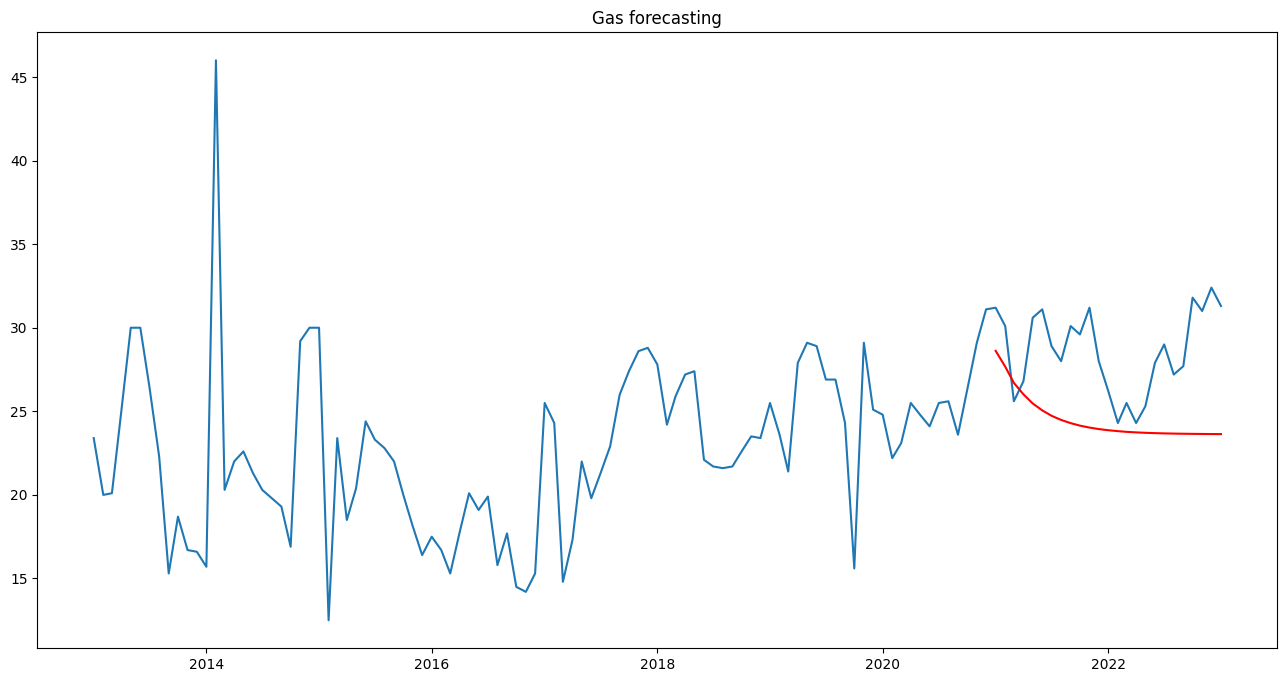

In [147]:
df_short = new_energy_df['Gas'].loc['2013':]
plt.plot(df_short.index, df_short, label='Observed')
plt.plot(forecast_df.index, forecast_df['Gas forecast'], color='red', label='Predicted')
plt.title('Gas forecasting')
plt.show()

Not great. They don't forecast as accurate as ARIMA. Even for Gas, it went downwards rather than upwards, so we can say that VAR does not work great for Gas and Water together.

So in conclusion, based on what I have done, the gas and water consumption can be predicted with ARIMA model but the variances of the forecast is not as great as it should be. While for electricity consumption, by doing regular differencing, and use SARIMA, the prediction would be very accurate thanks to its strong seasonality.

# References:

Prabhakaran, S. (2022) Granger causality test, Machine Learning Plus. Available at: https://www.machinelearningplus.com/time-series/granger-causality-test/?expand_article=1 (Accessed: 2 August 2023). 

Nau, R. (2020) Summary of rules for identifying ARIMA models, Rules for identifying Arima models. Available at: https://people.duke.edu/~rnau/arimrule.htm (Accessed: 04 August 2023). 

Hyndman, R.J. and Athanasopoulos, G. (2021) Forecasting: Principles and practice. Melbourne: OTexts. 

Bevans, R. (2023) Akaike information criterion: When &amp; how to use it (example), Scribbr. Available at: https://www.scribbr.com/statistics/akaike-information-criterion/ (Accessed: 04 August 2023). 